# Preliminaries

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from matplotlib import pyplot as plt
from matplotlib import cm
import msgpack

from stellarpunk import econ_sim, serialization

In [2]:
%load_ext autoreload
%autoreload 1
%aimport stellarpunk.serialization
%aimport stellarpunk.econ_sim

# Data Loading

## Economic Model

In [3]:
#production_chain_df = pd.DataFrame(msgpack.unpackb(open("/tmp/production_chain.log", "rb").read(), object_hook=serialization.decode_matrix))
production_chain = serialization.load_production_chain(open("/tmp/production_chain.log", "rb").read())
production_chain_df = production_chain.adj_matrix

In [4]:
production_chain_df.shape

(27, 27)

In [5]:
agent_goods_df = pd.DataFrame(msgpack.unpackb(open("/tmp/agent_goods.log", "rb").read(), object_hook=serialization.decode_matrix))

In [6]:
agent_goods_df.sum(axis=0)

0     28.0
1     54.0
2      8.0
3      8.0
4     37.0
5     42.0
6     23.0
7     24.0
8      6.0
9     10.0
10    16.0
11    16.0
12     6.0
13     4.0
14     2.0
15     1.0
16     2.0
17     4.0
18     1.0
19     1.0
20     1.0
21     1.0
22     1.0
23     1.0
24     1.0
25     1.0
26     1.0
dtype: float64

In [7]:
np.where(agent_goods_df.loc[31] == 1)

(array([6]),)

In [8]:
agent_goods_df.idxmax(axis=1).loc[146]

1

In [9]:
production_goods = agent_goods_df @ production_chain_df.T

## Loading Other Data

In [10]:
buy_price_df = serialization.read_tick_log_to_df(open("/tmp/buy_prices.log", "rb"), index_name="agent").reset_index()
buy_budget_df = serialization.read_tick_log_to_df(open("/tmp/buy_budget.log", "rb"), index_name="agent").reset_index()
sell_price_df = serialization.read_tick_log_to_df(open("/tmp/sell_prices.log", "rb"), index_name="agent", fill_values=np.inf).reset_index()
max_buy_price_df = serialization.read_tick_log_to_df(open("/tmp/max_buy_prices.log", "rb"), index_name="agent").reset_index()
min_sell_price_df = serialization.read_tick_log_to_df(open("/tmp/min_sell_prices.log", "rb"), index_name="agent", fill_values=np.inf).reset_index()

In [11]:
columns = ["tick", "product", "buyer", "seller", "price", "amount"]
transaction_df = pd.read_csv("/tmp/transactions.log", sep="\t", header=None, names=columns)

In [12]:
transaction_df["value"] = transaction_df["amount"] * transaction_df["price"]

In [13]:
cannot_buy_df = serialization.read_tick_log_to_df(open("/tmp/cannot_buy.log", "rb"), index_name="agent", fill_values=0.).reset_index()
cannot_sell_df = serialization.read_tick_log_to_df(open("/tmp/cannot_sell.log", "rb"), index_name="agent", fill_values=0.).reset_index()

In [14]:
balance_df = serialization.read_tick_log_to_df(open("/tmp/balance.log", "rb"), index_name="agent", column_names=["balance"])
balance_df.reset_index(inplace=True)

In [15]:
#columns = list(map(lambda x: str(x), range(production_chain_df.shape[0])))
columns=None
inventory_df = serialization.read_tick_log_to_df(open("/tmp/inventory.log", "rb"), index_name="agent", column_names=columns)
inventory_df.reset_index(inplace=True)

In [16]:
#production_efficiency_df = serialization.read_tick_log_to_df(open("/tmp/production_efficiency.log", "rb"), index_name="agent")

# Transactions

## Market Overview

In [17]:
transaction_df.groupby("product")[["amount", "value"]].sum()

,amount,value
product,,
-1,20674419.0,1.472692e+08
0,2754939.0,1.035640e+07
1,2665778.0,6.873674e+06
2,3017483.0,5.143386e+07
3,2230982.0,4.776581e+07
4,4822729.0,2.194714e+07
5,4030194.0,1.142936e+07
6,2639244.0,1.051795e+07
7,2522149.0,7.053605e+06


521003 transactions total


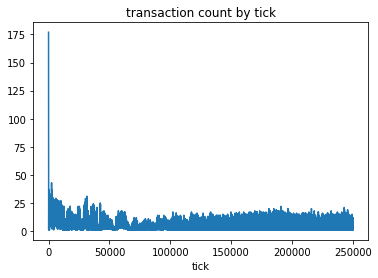

In [18]:
transaction_df.groupby("tick")["price"].count().plot()
plt.title("transaction count by tick")
print(f'{len(transaction_df)} transactions total')

Text(0.5, 1.0, 'product 0 transaction count per tick')

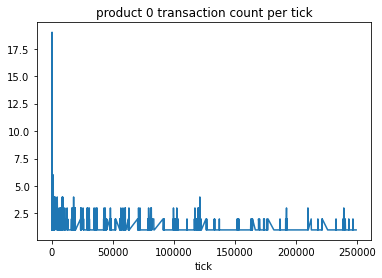

In [19]:
transaction_df[transaction_df["product"] == 0].groupby("tick")["price"].count().plot()
plt.title("product 0 transaction count per tick")

Text(0.5, 1.0, 'transaction unit quantity per tick')

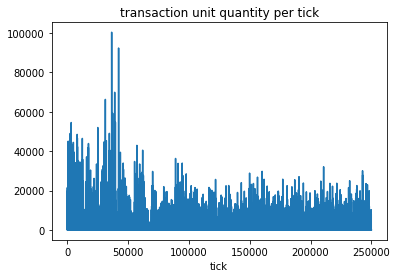

In [20]:
transaction_df.groupby("tick")["amount"].sum().plot()
plt.title("transaction unit quantity per tick")

Text(0.5, 1.0, 'transaction value per tick')

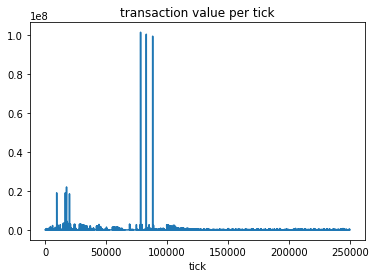

In [21]:
transaction_df.groupby("tick")["value"].sum().plot()
plt.title("transaction value per tick")

Text(0.5, 1.0, 'distinct products sold per tick')

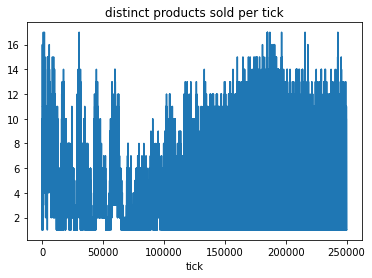

In [22]:
transaction_df.groupby("tick")["product"].nunique().plot()
plt.title("distinct products sold per tick") 

Text(0.5, 1.0, 'distinct sellers per tick')

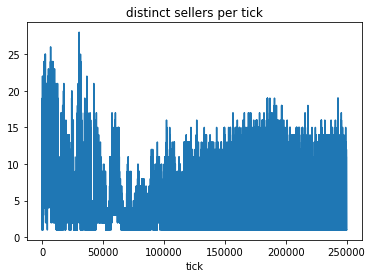

In [23]:
transaction_df.groupby("tick")["seller"].nunique().plot()
plt.title("distinct sellers per tick")

Text(0.5, 1.0, 'distinct buyers per tick')

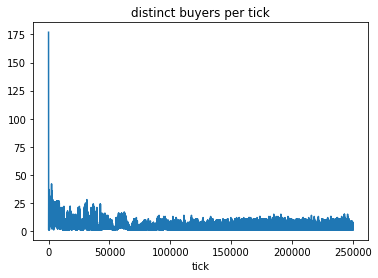

In [24]:
transaction_df.groupby("tick")["buyer"].nunique().plot()
plt.title("distinct buyers per tick")

In [25]:
transaction_df["seller"].nunique()

301

In [26]:
transaction_df["buyer"].nunique()

301

In [27]:
transaction_df["product"].nunique()

28

<AxesSubplot:>

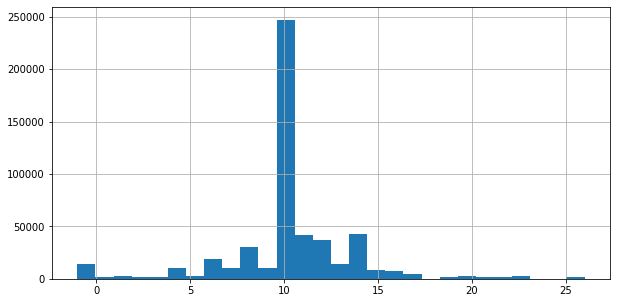

In [28]:
plt.figure(figsize=(10,5))
transaction_df["product"].hist(bins=transaction_df["product"].nunique())

Text(0.5, 1.0, 'max product id sold each tick')

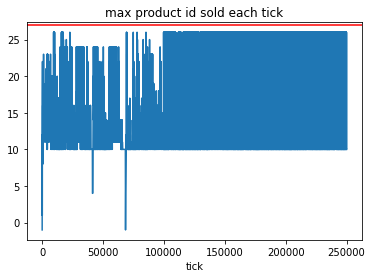

In [29]:
transaction_df.groupby("tick")["product"].max().plot()
plt.axhline(production_chain_df.shape[1], color="red")
plt.title("max product id sold each tick")

## Further Exploration

In [30]:
transaction_df[transaction_df["seller"] == 3]["price"].describe()

count    164.000000
mean      21.823324
std        1.629092
min       20.845522
25%       20.926138
50%       21.090450
75%       22.260966
max       28.128479
Name: price, dtype: float64

Text(0.5, 1.0, 'price of product 0 over time')

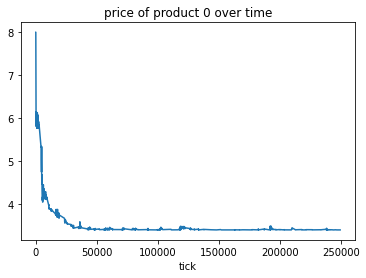

In [31]:
transaction_df[transaction_df["product"] == 0].groupby("tick")["price"].mean().plot()
plt.title("price of product 0 over time")

Text(0.5, 1.0, 'price of product 3 over time')

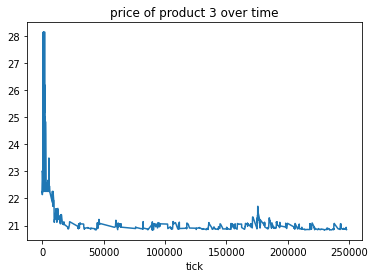

In [32]:
transaction_df[transaction_df["product"] == 3].groupby("tick")["price"].mean().plot()
plt.title("price of product 3 over time")

<AxesSubplot:>

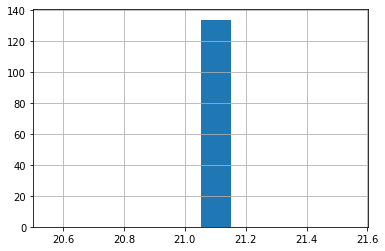

In [33]:
transaction_df[transaction_df["buyer"] == 3]["price"].hist()

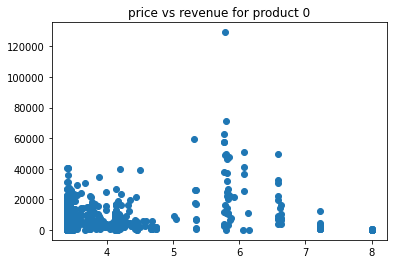

In [34]:
plt.scatter(transaction_df[transaction_df["product"] == 0].groupby("tick")["price"].mean(), transaction_df[transaction_df["product"] == 0].groupby("tick")["value"].sum())
plt.title("price vs revenue for product 0")
plt.show()

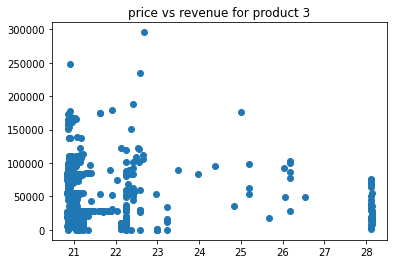

In [35]:
plt.scatter(transaction_df[transaction_df["product"] == 3].groupby("tick")["price"].mean(), transaction_df[transaction_df["product"] == 3].groupby("tick")["value"].sum())
plt.title("price vs revenue for product 3")
plt.show()

In [36]:
transaction_df[(transaction_df["price"] > 12) & (transaction_df["product"] == 0)]

,tick,product,buyer,seller,price,amount,value


In [37]:
transaction_df.groupby("product").agg({"tick":"max", "price":"mean", "amount":"sum", "value":"sum"})

,tick,price,amount,value
product,,,,
-1,249954,6.218092e+00,20674419.0,1.472692e+08
0,249515,3.936679e+00,2754939.0,1.035640e+07
1,249224,2.654409e+00,2665778.0,6.873674e+06
2,247982,1.722418e+01,3017483.0,5.143386e+07
3,247763,2.183012e+01,2230982.0,4.776581e+07
4,249953,4.544421e+00,4822729.0,2.194714e+07
5,249953,2.931760e+00,4030194.0,1.142936e+07
6,248202,4.346281e+00,2639244.0,1.051795e+07
7,249296,3.002765e+00,2522149.0,7.053605e+06


## Transaction Graph

### By Agent

In [38]:
transaction_df.groupby(["buyer", "seller"])["amount"].sum().to_frame().reset_index()

,buyer,seller,amount
0,-1,24,131.0
1,-1,25,7.0
2,-1,26,1948.0
3,0,-1,66232.0
4,1,-1,23585.0
...,...,...,...
2400,295,269,10.0
2401,296,-1,129442.0
2402,297,-1,25593.0
2403,298,-1,143520.0


In [39]:
G = nx.from_pandas_edgelist(
    transaction_df.groupby(["buyer", "seller"])["amount"].sum().to_frame().reset_index(),
    source="seller", target="buyer", edge_attr="amount", create_using=nx.DiGraph)

In [40]:
labels = pd.DataFrame(transaction_df.groupby("seller")["product"].first()).apply(lambda x: f'{x.name}:{x["product"]}', axis=1)

In [41]:
G = nx.relabel_nodes(G, labels)

In [42]:
nx.is_directed_acyclic_graph(G)

False

In [43]:
# this is pretty slow for lots of agents
#plt.figure(figsize=(15, 15))
#pos = graphviz_layout(G, prog='dot')
#nx.draw(G, pos, with_labels=True, arrows=True)
#nx.draw_networkx_edge_labels(G, pos)
#plt.show()

### By Good

In [44]:
augmented_transaction_df = transaction_df.merge(agent_goods_df.idxmax(axis=1).rename("buyer_product"), how="left", left_on="buyer", right_index=True)
augmented_transaction_df["buyer_product"].fillna(-2, inplace=True)
product_flow = augmented_transaction_df.groupby(["product", "buyer_product"])["value"].sum().to_frame().reset_index().rename({"buyer_product":"target", "product":"source", "amount":"value"}, axis=1)

In [45]:
agent_goods_df.columns

RangeIndex(start=0, stop=27, step=1)

In [46]:
set(agent_goods_df.columns) - set(product_flow["source"].unique())

set()

In [47]:
set(agent_goods_df.columns) - set(product_flow["target"].unique())

set()

In [48]:
from ipysankeywidget import SankeyWidget
from ipywidgets import Layout
sankey = SankeyWidget(layout=Layout(height='680', width='1024'), links=product_flow.to_dict("records"))
sankey

SankeyWidget(layout=Layout(height='680', width='1024'), links=[{'source': -1, 'target': 0.0, 'value': 10213617…

In [49]:
from IPython.display import (
    Image,
    SVG
)
import base64
data = base64.decodebytes(bytes(sankey.png, 'ascii'))
Image(data)

## Indicators by Market

In [50]:
transactions_by_product = pd.DataFrame({"producers":agent_goods_df.sum(axis=0), "sellers":transaction_df.groupby("product")["seller"].nunique()})
transactions_by_product["zero_sales"] = transactions_by_product["producers"] - transactions_by_product["sellers"]
transactions_by_product["seller_value_cv"] = transaction_df.groupby(["product", "seller"])["value"].sum().groupby("product").std() / transaction_df.groupby(["product", "seller"])["value"].sum().groupby("product").mean()
transactions_by_product["transactions"] = transaction_df.groupby("product")["price"].count()
transactions_by_product["total_amount"] = transaction_df.groupby("product")["amount"].sum()
transactions_by_product["total_value"] = transaction_df.groupby("product")["value"].sum()
transactions_by_product["price"] = transaction_df.groupby("product")["price"].mean()
transactions_by_product["price_cv"] = transaction_df.groupby("product")["price"].std() / transaction_df.groupby("product")["price"].mean()
transactions_by_product["first_tick"] = transaction_df.groupby("product")["tick"].min()
transactions_by_product["last_tick"] = transaction_df.groupby("product")["tick"].max()

transactions_by_product

,producers,sellers,zero_sales,seller_value_cv,transactions,total_amount,total_value,price,price_cv,first_tick,last_tick
-1,NaN,1,NaN,NaN,13955,20674419.0,1.472692e+08,6.218092e+00,0.981902,0,249954
0,28.0,28,0.0,0.443102,1900,2754939.0,1.035640e+07,3.936679e+00,0.257591,74,249515
1,54.0,54,0.0,0.605202,2579,2665778.0,6.873674e+06,2.654409e+00,0.139899,74,249224
2,8.0,8,0.0,0.074949,1969,3017483.0,5.143386e+07,1.722418e+01,0.050609,74,247982
3,8.0,8,0.0,0.068995,1350,2230982.0,4.776581e+07,2.183012e+01,0.080916,74,247763
4,37.0,37,0.0,0.082077,10091,4822729.0,2.194714e+07,4.544421e+00,0.132681,74,249953
5,42.0,42,0.0,0.289992,2799,4030194.0,1.142936e+07,2.931760e+00,0.233471,74,249953
6,23.0,23,0.0,2.011177,19129,2639244.0,1.051795e+07,4.346281e+00,0.352557,82,248202
7,24.0,24,0.0,2.007679,10634,2522149.0,7.053605e+06,3.002765e+00,0.372028,80,249296
8,6.0,6,0.0,0.722393,30302,2969873.0,5.486865e+07,1.884378e+01,0.196143,78,246743


Text(0.5, 1.0, 'mean prices by products')

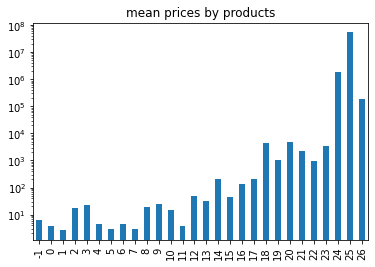

In [51]:
transactions_by_product["price"].plot.bar()
plt.yscale("log")
plt.title("mean prices by products")

Text(0.5, 1.0, 'cv by product')

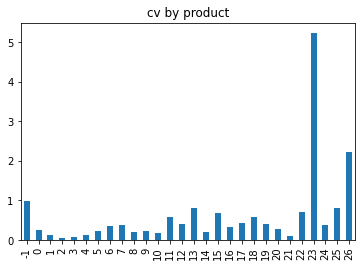

In [52]:
transactions_by_product["price_cv"].plot.bar()
plt.title("cv by product")

Text(0.5, 0.98, 'Prices for goods over time')

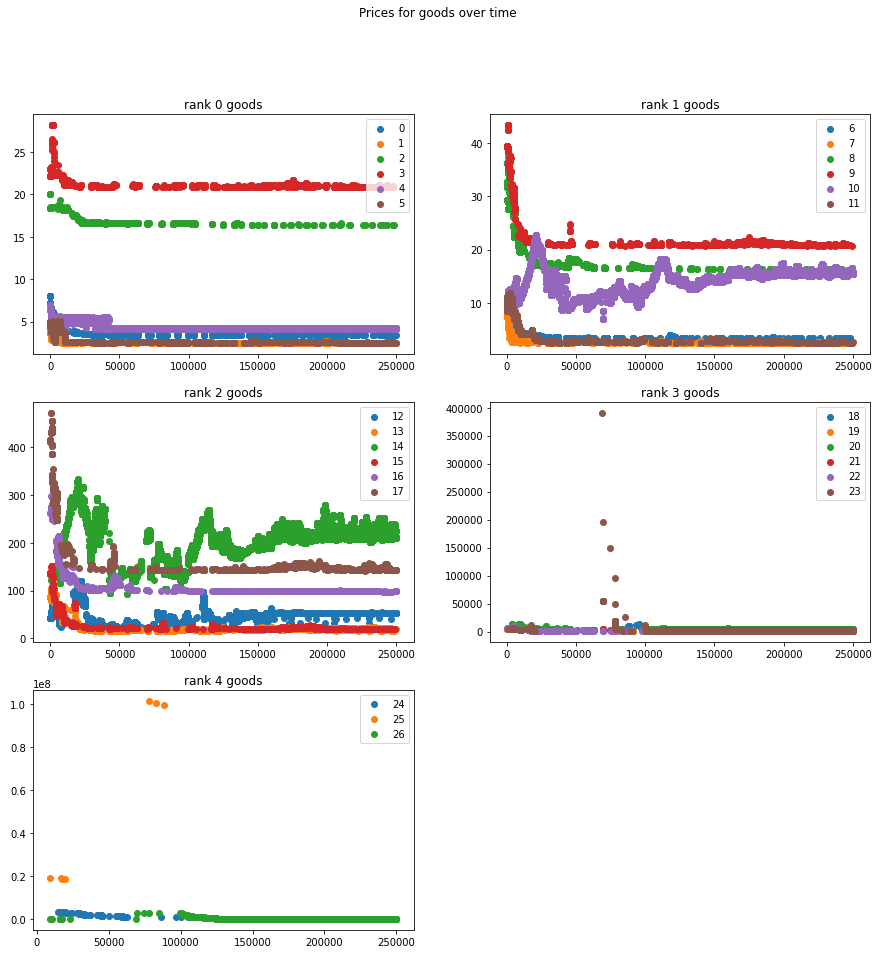

In [53]:
price_by_tick = transaction_df.groupby(["tick", "product"])["price"].mean().to_frame().reset_index()

a = np.insert(production_chain.ranks.cumsum(), 0,0)
rank_ranges = list(zip(a[0:-1], a[1:]))

fig, axs = plt.subplots(int(np.ceil(len(rank_ranges)/2)),2, figsize=(15,15))
if len(rank_ranges) % 2 == 1:
    fig.delaxes(axs.flatten()[-1])
for i,rng in enumerate(rank_ranges):
    ax = axs.flatten()[i]
    for product in range(rng[0], rng[1]):
        ax.scatter(price_by_tick[price_by_tick["product"] == product]["tick"], price_by_tick[price_by_tick["product"] == product]["price"], label=f'{product}')
    ax.title.set_text(f'rank {i} goods')
    ax.legend(loc="upper right")
    
fig.suptitle("Prices for goods over time")

In [54]:
buy_price_melt = buy_price_df.melt(id_vars=["agent", "tick"], value_vars=list(range(production_chain.ranks.sum())), var_name="product", value_name="price")
buy_price_melt = buy_price_melt[buy_price_melt["price"] > 0]
buy_price_by_tick = buy_price_melt.groupby(["tick", "product"])["price"].max()
sell_price_melt = sell_price_df.melt(id_vars=["agent", "tick"], value_vars=list(range(production_chain.ranks.sum())), var_name="product", value_name="price")
sell_price_melt = sell_price_melt[sell_price_melt["price"] < np.inf]
sell_price_by_tick = sell_price_melt.groupby(["tick", "product"])["price"].min()

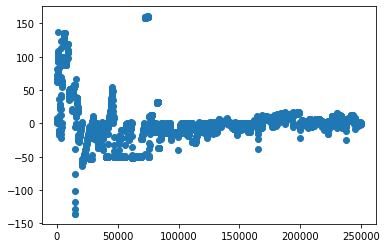

In [55]:
price_diffs = (buy_price_by_tick - sell_price_by_tick).to_frame().reset_index()
plt.scatter(price_diffs[price_diffs["product"] == 17]["tick"],price_diffs[price_diffs["product"] == 17]["price"])

Text(0.5, 0.98, 'Buy/sell price diffs for goods over time')

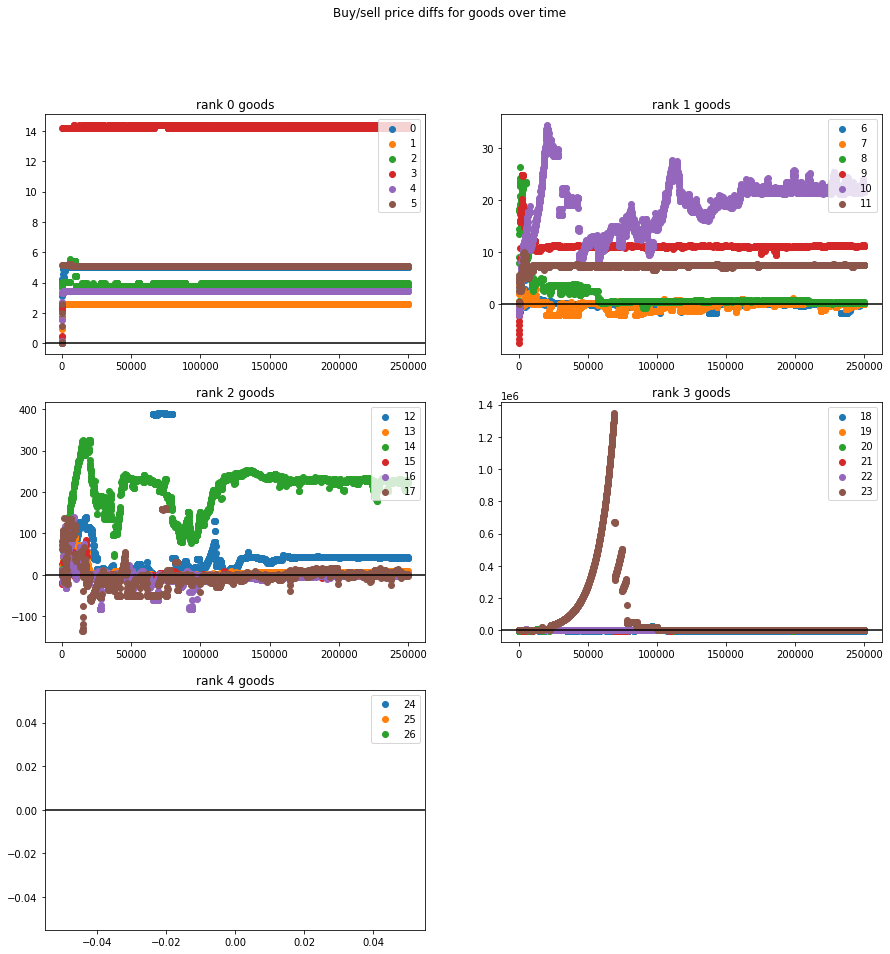

In [56]:
price_diffs = (buy_price_by_tick - sell_price_by_tick).to_frame().reset_index()

a = np.insert(production_chain.ranks.cumsum(), 0,0)
rank_ranges = list(zip(a[0:-1], a[1:]))

fig, axs = plt.subplots(int(np.ceil(len(rank_ranges)/2)),2, figsize=(15,15))
if len(rank_ranges) % 2 == 1:
    fig.delaxes(axs.flatten()[-1])
for i,rng in enumerate(rank_ranges):
    ax = axs.flatten()[i]
    for product in range(rng[0], rng[1]):
        ax.scatter(price_diffs[price_diffs["product"] == product]["tick"], price_diffs[price_diffs["product"] == product]["price"], label=f'{product}')
    ax.axhline(0, color="black")
    ax.title.set_text(f'rank {i} goods')
    ax.legend(loc="upper right")
    
fig.suptitle("Buy/sell price diffs for goods over time")

# Balance

In [57]:
balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent")

,tick,balance
agent,,
0,0,1165.684477
1,0,575.366876
2,0,2834.220231
3,0,3239.482521
4,0,1011.164418
...,...,...
295,0,9450.000000
296,0,724.678211
297,0,575.366876


In [58]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent")

,tick,balance
agent,,
0,249952,3.038690
1,249952,0.852773
2,249952,10.499552
3,249952,12.987090
4,249952,38885.918492
...,...,...
295,249952,1.607011
296,249952,10094.159022
297,249952,1.130583


In [59]:
#balance_df.groupby("tick")["balance"].sum().plot()

In [60]:
balance_df[balance_df["tick"] == balance_df["tick"].min()]["balance"].describe()

count    3.000000e+02
mean     3.854422e+06
std      5.414826e+07
min      5.753669e+02
25%      7.246782e+02
50%      1.165684e+03
75%      9.900000e+03
max      9.229034e+08
Name: balance, dtype: float64

In [61]:
balance_df[balance_df["tick"] == balance_df["tick"].max()]["balance"].describe()

count    3.000000e+02
mean     6.623043e+06
std      7.294452e+07
min      1.757173e-02
25%      1.661747e+00
50%      1.012809e+01
75%      8.129326e+04
max      1.190901e+09
Name: balance, dtype: float64

In [62]:
ltb_df = balance_df[balance_df["tick"] == balance_df["tick"].max()]

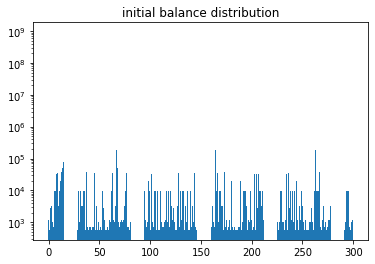

In [63]:
plt.bar(balance_df[balance_df["tick"] == balance_df["tick"].min()]["agent"], balance_df[balance_df["tick"] == balance_df["tick"].min()]["balance"])
plt.title("initial balance distribution")
plt.yscale("log")

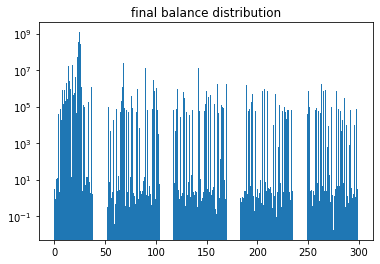

In [64]:
plt.bar(balance_df[balance_df["tick"] == balance_df["tick"].max()]["agent"], balance_df[balance_df["tick"] == balance_df["tick"].max()]["balance"])
plt.title("final balance distribution")
plt.yscale("log")

In [65]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent")["balance"]-balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent")["balance"]

agent
0      -1162.645786
1       -574.514103
2      -2823.720679
3      -3226.495430
4      37874.754074
           ...     
295    -9448.392989
296     9369.480811
297     -574.236293
298    72458.474020
299    -1162.790012
Name: balance, Length: 300, dtype: float64

<AxesSubplot:xlabel='agent'>

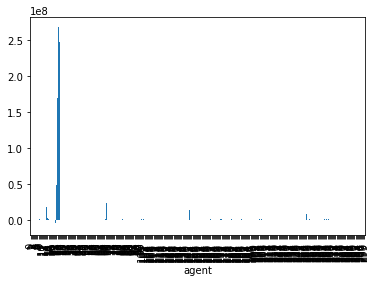

In [66]:
(balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent")["balance"]-balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent")["balance"]).plot.bar()

In [67]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent")["balance"]

agent
0          3.038690
1          0.852773
2         10.499552
3         12.987090
4      38885.918492
           ...     
295        1.607011
296    10094.159022
297        1.130583
298    73469.638438
299        2.894464
Name: balance, Length: 300, dtype: float64

In [68]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].head(50)

,agent,tick,balance
1027200,0,249952,3.038690e+00
1027201,1,249952,8.527730e-01
1027202,2,249952,1.049955e+01
1027203,3,249952,1.298709e+01
1027204,4,249952,3.888592e+04
1027205,5,249952,2.000320e+00
1027206,6,249952,7.779723e+04
1027207,7,249952,1.949821e+04
1027208,8,249952,8.485663e+05
1027209,9,249952,1.439061e+05


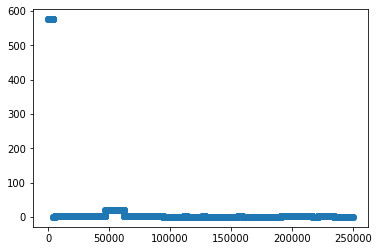

In [69]:
plt.scatter(balance_df[balance_df["agent"] == 1]["tick"],balance_df[balance_df["agent"] == 1]["balance"])

In [70]:
#for agent in balance_df["agent"].unique():
#    plt.scatter(balance_df[balance_df["agent"] == agent]["tick"], balance_df[balance_df["agent"] == agent]["balance"])


In [71]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].drop("tick", axis=1).set_index("agent") / balance_df[balance_df["tick"] == balance_df["tick"].min()].drop("tick", axis=1).set_index("agent")

,balance
agent,
0,0.002607
1,0.001482
2,0.003705
3,0.004009
4,38.456573
...,...
295,0.000170
296,13.929160
297,0.001965


# Inventory

## Last Tick Inventory

In [72]:
inventory_df[inventory_df["tick"] == inventory_df["tick"].max()]

,agent,tick,0,1,2,3,4,5,6,7,...,17,18,19,20,21,22,23,24,25,26
1027200,0,249952,1694.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1027201,1,249952,0.0,585.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1027202,2,249952,0.0,0.0,8678.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1027203,3,249952,0.0,0.0,0.0,4349.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1027204,4,249952,0.0,0.0,0.0,0.0,11081.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1027495,295,249952,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4557.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1027496,296,249952,0.0,0.0,0.0,0.0,0.0,15781.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1027497,297,249952,0.0,696.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1027498,298,249952,0.0,0.0,0.0,0.0,5841.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Produced Goods Inventory

In [73]:
agent_goods_df * inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent")

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,tick
0,1694.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,0.0,585.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,8678.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,4349.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,0.0,11081.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4557.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
296,0.0,0.0,0.0,0.0,0.0,15781.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
297,0.0,696.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
298,0.0,0.0,0.0,0.0,5841.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


### Input Resources Inventory

In [74]:
inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent") - agent_goods_df * inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent")

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,tick
agent,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [75]:
(inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent") - agent_goods_df * inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent")) - (agent_goods_df @ production_chain_df.T)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,tick
agent,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


## Production Surplus/Deficit

In [76]:
agent_id = 22
target_tick = np.inf

target_tick = np.clip(target_tick, 0, inventory_df["tick"].max())

#inv_s = inventory_df[inventory_df["tick"] == target_tick].set_index("agent").loc[agent_id].drop("tick")
inv_s = inventory_df.drop("tick", axis=1).groupby("agent").mean().loc[agent_id]
need_s = (agent_goods_df.loc[agent_id] @ production_chain_df.T)
batch_s = (agent_goods_df * production_chain.batch_sizes[np.newaxis,:]).loc[agent_id] @ production_chain_df.T
deficit_df = pd.DataFrame({"inventory":inv_s, "unit_need":need_s, "batch_need": batch_s, "surplus":inv_s - batch_s, "batches":inv_s/batch_s})
deficit_df

,inventory,unit_need,batch_need,surplus,batches
0,0.000000,0.0,0.0,0.000000,NaN
1,0.000000,0.0,0.0,0.000000,NaN
2,0.000000,0.0,0.0,0.000000,NaN
3,0.000000,0.0,0.0,0.000000,NaN
4,0.000000,0.0,0.0,0.000000,NaN
5,0.000000,0.0,0.0,0.000000,NaN
6,0.000000,0.0,0.0,0.000000,NaN
7,0.000000,0.0,0.0,0.000000,NaN
8,0.000000,0.0,0.0,0.000000,NaN
9,0.000000,0.0,0.0,0.000000,NaN


In [77]:
balance_df[(balance_df["agent"] == agent_id) & (balance_df["tick"] == target_tick)]

,agent,tick,balance
1027222,22,249952,45271.263963


In [78]:
buy_price_df[(buy_price_df["tick"] == target_tick) & (buy_price_df["agent"] == agent_id)].T

,1027222
agent,22.000000
tick,249952.000000
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
5,0.000000
6,0.000000
7,0.000000


In [79]:
buy_budget_df[(buy_budget_df["tick"] == target_tick) & (buy_budget_df["agent"] == agent_id)].T

,1027222
agent,22.000000
tick,249952.000000
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
5,0.000000
6,0.000000
7,0.000000


In [80]:
inventory_df[inventory_df["agent"] == agent_id].drop("agent", axis=1).set_index("tick")[agent_id].describe()

count    3425.000000
mean     3704.071825
std      1548.188437
min         0.000000
25%      3122.000000
50%      3852.000000
75%      5157.000000
max      5697.000000
Name: 22, dtype: float64

# Buy and Sell Prices

In [81]:
max_last_buy_price = buy_price_df[buy_price_df["tick"] == buy_price_df["tick"].max()].drop(["agent", "tick"], axis=1).max(axis=0)
min_last_sell_price = sell_price_df[sell_price_df["tick"] == sell_price_df["tick"].max()].drop(["agent", "tick"], axis=1).min(axis=0)
#max_last_buy_price - min_last_sell_price
min_last_sell_price

0     3.431552e+00
1     2.438679e+00
2     1.641220e+01
3     2.105175e+01
4     3.883558e+00
5     2.506857e+00
6     3.363265e+00
7     2.454895e+00
8     1.641220e+01
9     2.084664e+01
10    5.023875e+00
11    2.560297e+00
12    3.206961e+01
13    1.587990e+01
14    1.263049e+02
15    2.020726e+01
16    9.976439e+01
17    1.447403e+02
18    3.551893e+03
19    1.041765e+03
20    4.797758e+03
21    2.351700e+03
22    8.679352e+02
23    1.117256e+03
24    9.044277e+05
25    9.836653e+07
26    5.389362e+04
dtype: float64

## Market Analysis for one Good

### Overview of one Market

In [82]:
product_id = 3
min_ticks = 0
max_ticks = np.inf

max_ticks = np.clip(max_ticks, 0, sell_price_df["tick"].max())

dfsp = sell_price_df[(sell_price_df[product_id] < np.inf) & (sell_price_df["tick"].between(min_ticks,max_ticks))][["agent", "tick", product_id]].merge(inventory_df[["agent", "tick", product_id]], on=["tick", "agent"], suffixes=("","_inventory")).rename({str(product_id): product_id}, axis=1)
dfms = min_sell_price_df[(min_sell_price_df[product_id] < np.inf) & (min_sell_price_df["tick"].between(min_ticks,max_ticks))][["agent", "tick", product_id]].merge(inventory_df[["agent", "tick", product_id]], on=["tick", "agent"], suffixes=("","_inventory")).rename({str(product_id): product_id}, axis=1)

df1 = dfsp[dfsp[f'{product_id}_inventory'] > 0].groupby("tick")[product_id].min().to_frame()
df1_mean = dfsp[dfsp[f'{product_id}_inventory'] > 0].groupby("tick")[product_id].mean().to_frame()
df1_max = dfsp[dfsp[f'{product_id}_inventory'] > 0].groupby("tick")[product_id].max().to_frame()
dfms = dfms[dfms[f'{product_id}_inventory'] > 0].groupby("tick")[product_id].min().to_frame()
df2 = buy_price_df[(buy_price_df["tick"].between(min_ticks, max_ticks)) & (buy_price_df[product_id] > 0)][["tick", "agent", product_id]]
df2[product_id] = df2[product_id]
dfmb = max_buy_price_df[(max_buy_price_df["tick"].between(min_ticks, max_ticks)) & (max_buy_price_df[product_id] > 0)][["tick", "agent", product_id]]
dfmb[product_id] = dfmb[product_id]

buyer_df = buy_budget_df[(buy_budget_df[product_id] > 0) & buy_budget_df["tick"].between(min_ticks, max_ticks)][["tick", "agent", product_id]].merge(df2, on=["tick", "agent"], suffixes=["_budget", "_price"])
buyer_df["units"] = buyer_df[f'{product_id}_budget'] / buyer_df[f'{product_id}_price']
seller_df = inventory_df[inventory_df["tick"].between(min_ticks, max_ticks) & inventory_df["agent"].isin(np.where(agent_goods_df[product_id])[0])].groupby("tick")[product_id].sum()
seller_df = seller_df.loc[min_ticks:max_ticks]


Seller prices

In [83]:
sell_price_df[(sell_price_df[product_id] < np.inf) & sell_price_df["tick"].between(min_ticks, max_ticks)].groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
3,3425.0,21.052571,0.195541,20.84123,21.051748,21.051748,21.051748,25.262098
32,3425.0,21.040587,0.075090,20.84123,21.051748,21.051748,21.051748,23.000000
33,3425.0,21.042124,0.074525,20.84123,21.051748,21.051748,21.051748,23.000000
75,3425.0,21.041755,0.074477,20.84123,21.051748,21.051748,21.051748,23.000000
135,3425.0,21.043476,0.073111,20.84123,21.051748,21.051748,21.051748,23.000000
156,3425.0,21.042246,0.074193,20.84123,21.051748,21.051748,21.051748,23.000000
216,3425.0,21.055414,0.199066,20.84123,21.051748,21.051748,21.051748,25.262098
271,3425.0,21.041509,0.074963,20.84123,21.051748,21.051748,21.051748,23.000000


Buyer Prices

In [84]:
buyer_df.groupby("agent")[f'{product_id}_price'].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
9,31.0,33.045866,4.386110,23.000000,33.757899,35.201547,35.201547,35.201547
45,10.0,28.952689,6.004011,23.000000,23.291078,28.614312,34.841924,35.203043
63,23.0,24.831852,1.079358,23.000000,23.822711,25.162476,25.933088,25.933088
77,575.0,20.987071,0.841898,10.546919,20.910853,20.983046,21.074592,23.470517
128,48.0,24.012477,0.276311,23.000000,24.117289,24.117289,24.117289,24.117289
144,18.0,23.721450,0.404905,23.000000,23.529152,23.706978,23.706978,24.669577
154,148.0,21.780359,1.143546,20.677664,20.898416,21.041634,23.470378,23.470378
166,361.0,21.186858,0.609241,20.737939,20.928973,20.972368,21.111463,23.470354
218,458.0,21.260094,0.725608,20.667385,20.912998,21.021072,21.091758,23.470309


#### Market Volume

46733.0


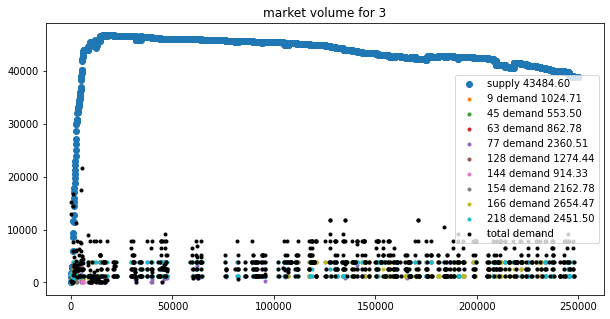

In [85]:
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
plt.figure(figsize=(10,5))
plt.scatter(seller_df[seller_df>0].index, seller_df[seller_df>0], label=f'supply {seller_df.mean():.2f}')
for agent_id, color in zip(buyer_df["agent"].unique(), colors[1:]):
    plt.scatter(buyer_df[buyer_df["agent"] == agent_id]["tick"], buyer_df[buyer_df["agent"] == agent_id]["units"], label=f'{agent_id} demand {buyer_df[buyer_df["agent"] == agent_id]["units"].mean():.2f}', marker=".")
total_demand = buyer_df.groupby("tick")["units"].sum()
plt.scatter(total_demand.index, total_demand, label="total demand", marker=".", color="black")
plt.legend(loc="right")
plt.title(f'market volume for {product_id}')
print(seller_df.max())

In [86]:
seller_df[seller_df > 0].index.to_series().describe()

count      3425.0000
mean     124976.0000
std       72186.5364
min           0.0000
25%       62488.0000
50%      124976.0000
75%      187464.0000
max      249952.0000
Name: tick, dtype: float64

In [87]:
seller_df.describe()

count     3425.000000
mean     43484.597080
std       4107.263202
min         80.000000
25%      42451.000000
50%      44296.000000
75%      45820.000000
max      46733.000000
Name: 3, dtype: float64

In [88]:
buyer_df.groupby("agent")["units"].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
9,31.0,1024.709677,622.780335,1.0,970.50,1050.0,1067.00,2778.0
45,10.0,553.500000,781.298670,1.0,18.00,106.0,786.00,2250.0
63,23.0,862.782609,1263.655338,1.0,1.00,430.0,1121.00,3935.0
77,575.0,2360.511304,1336.726596,1.0,1307.00,1523.0,3934.00,3942.0
128,48.0,1274.437500,903.992019,1.0,1070.75,1231.0,1231.25,3941.0
144,18.0,914.333333,1175.247408,1.0,1.00,217.0,1453.75,3782.0
154,148.0,2162.777027,1257.632177,1.0,1256.75,1311.0,3934.00,3942.0
166,361.0,2654.468144,1271.586765,1.0,1308.00,2625.0,3934.00,3942.0
218,458.0,2451.497817,1252.970729,18.0,1308.25,1314.0,3937.00,3942.0


In [89]:
cannot_buy_df[cannot_buy_df["tick"].between(min_ticks, max_ticks) & cannot_buy_df["agent"].isin(np.where(production_goods[product_id])[0])][["agent", "tick", product_id]].groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
9,3425.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
45,3425.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
63,3425.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
77,3425.0,7.182774,42.045041,0.0,0.0,0.0,0.0,511.0
128,3425.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
144,3425.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
154,3425.0,1.300146,16.165863,0.0,0.0,0.0,0.0,365.0
166,3425.0,4.625109,32.514063,0.0,0.0,0.0,0.0,511.0
218,3425.0,3.729927,27.219873,0.0,0.0,0.0,0.0,511.0


In [90]:
df2[product_id].max()

35.20520959658306

In [91]:
df2.groupby("tick")[product_id].describe().describe()

,count,mean,std,min,25%,50%,75%,max
count,3425.0,3425.000000,3425.000000,3425.000000,3425.000000,3425.000000,3425.000000,3425.000000
mean,10.0,26.376459,5.672908,21.031889,21.749152,24.381901,31.797543,35.187801
std,0.0,0.236003,0.275338,0.581447,0.573577,0.083132,0.338251,0.455402
min,10.0,23.000000,0.000000,10.546919,20.883203,23.000000,23.000000,23.000000
25%,10.0,26.209083,5.597099,20.896707,21.198767,24.394262,31.801696,35.205210
50%,10.0,26.402254,5.668163,20.943704,21.712390,24.394262,31.801696,35.205210
75%,10.0,26.472703,5.810212,21.038654,22.136053,24.394262,31.801696,35.205210
max,10.0,27.324859,7.393027,23.470185,23.470413,24.394262,32.884432,35.205210


#### Market Price

is there a transaction?
do the sellers have inventory?
do any buyers demand goods?
are prices compatible?
is at least one agent in the cannot buy state (> 100 ticks)


Text(0.5, 1.0, 'price chart for 3')

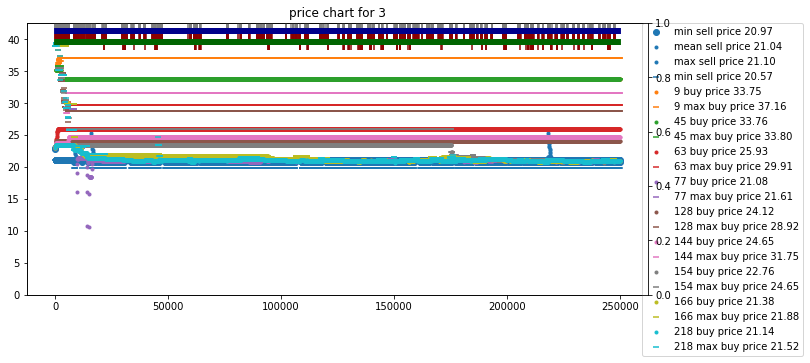

In [92]:
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
plt.figure(figsize=(15,5))
plt.scatter(df1.index, df1[product_id], label=f'min sell price {df1[product_id].mean():.2f}', color=colors[0])
plt.scatter(df1_mean.index, df1_mean[product_id], label=f'mean sell price {df1_mean[product_id].mean():.2f}', color=colors[0], marker=".")
plt.scatter(df1_mean.index, df1_max[product_id], label=f'max sell price {df1_max[product_id].mean():.2f}', color=colors[0], marker=".")
plt.scatter(dfms.index, dfms[product_id], label=f'min sell price {dfms[product_id].mean():.2f}', marker="_", color=colors[0])
for agent, color in zip(df2["agent"].unique(), colors[1:]):
    plt.scatter(df2[df2["agent"] == agent]["tick"], df2[df2["agent"] == agent][product_id], label=f'{agent} buy price {df2[df2["agent"] == agent][product_id].mean():.2f}', marker=".", color=color)
    plt.scatter(dfmb[dfmb["agent"] == agent]["tick"], dfmb[dfmb["agent"] == agent][product_id], label=f'{agent} max buy price {dfmb[dfmb["agent"] == agent][product_id].mean():.2f}', marker="_", color=color)
if len(df2) > 0:
    plt.ylim(0, df2[product_id].max()*1.1)
plt.ylim(plt.ylim()[0], plt.ylim()[1]*1.1)

#plt.legend(loc="right")
plt.legend(bbox_to_anchor=(1.25, 1), borderaxespad=0)

# some status indicators
ax2 = plt.twinx()
print("is there a transaction?")
ax2.vlines(transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)]["tick"], ymin=0.98, ymax=1, color="gray")
print("do the sellers have inventory?")
ax2.vlines(seller_df[seller_df>0].index, ymin=0.96, ymax=0.98, color="darkblue")
print("do any buyers demand goods?")
ax2.vlines(buyer_df["tick"].unique()[(buyer_df.groupby("tick")["units"].sum() > 0)], ymin=0.94, ymax=0.96, color="darkred")
print("are prices compatible?")
price_diff = (df2.groupby("tick")[product_id].max() - df1[product_id]).rename("price_diff")
ax2.vlines(df1.join(price_diff[price_diff>0]).index, ymin=0.92, ymax=0.94, color="darkgreen")
print("is at least one agent in the cannot buy state (> 100 ticks)")
ax2.vlines(cannot_buy_df[cannot_buy_df["tick"].between(min_ticks, max_ticks)]["tick"].unique()[(cannot_buy_df[cannot_buy_df["tick"].between(min_ticks, max_ticks)].groupby("tick")[product_id].max() > 100)], ymin=0.90, ymax=0.92, color="darkred")
ax2.set_ylim(0,1)
plt.subplots_adjust(right=0.7)

plt.title(f'price chart for {product_id}')

#plt.tight_layout(rect=[0, 0, 0.75, 1])



In [93]:
transaction_df[transaction_df["tick"].between(min_ticks, max_ticks) & (transaction_df["product"] == product_id)]

,tick,product,buyer,seller,price,amount,value
177,74,3,63,271,23.000000,10.0,230.000000
208,75,3,77,271,23.000000,18.0,414.000000
209,75,3,236,156,23.000000,10.0,230.000000
233,76,3,166,135,23.000000,10.0,230.000000
245,77,3,218,216,23.000000,10.0,230.000000
...,...,...,...,...,...,...,...
517572,247472,3,166,75,20.935905,417.0,8730.272463
517573,247472,3,218,75,20.846376,1310.0,27308.752396
517574,247472,3,154,75,20.845923,1310.0,27308.158814
517873,247690,3,154,271,20.862667,3946.0,82324.082860


#### Ticks when max buy price changes a lot

In [94]:
def consecutive_diffs(x):
    return x.iloc[1] - x.iloc[0]
    print(x)
    raise Exception(x.__class__)
mb_diffs = dfmb.set_index("tick").groupby("agent")[product_id].rolling(2).apply(consecutive_diffs)
mb_diffs.to_frame().sort_values(["agent", product_id], key=abs, ascending=False).groupby("agent").head(5)

3
agent tick             
236   1022    -4.316522
      1168    -4.145210
      949      3.949155
      1095     3.465924
      1387    -2.200047
218   1022    -4.316869
      1168    -4.119183
      949      3.949501
      2336    -3.829090
      45479    3.686599
166   4964    -8.806631
      8395    -5.191731
      1022    -4.317629
      949      3.950340
      8833    -1.869567
154   1022    -4.291307
      949      3.923939
      175419  -3.509927
      1095    -3.440679
      3285    -2.755067
144   4964   -10.881209
      5475     2.245409
      5183     1.490858
      5329    -0.642588
      219      0.195385
128   1022    -4.287838
      949      3.920471
      1095    -3.440680
      3504    -2.751696
      5548    -2.309995
77    4964    -9.013889
      8395    -4.515833
      45479    3.626426
      46136   -2.241430
      9417    -1.649365
63    4964    -8.807665
      1022    -4.317555
      949      3.950294
      5548    -0.493448
      219      0.195278
45    1022    -4.313976
      949      3.946609
      1095    -3.194847
      2555    -2.069544
      219      0.195385
9     1022    -4.317741
      1168    -4.146405
      949      3.950376
      1095     3.467118
      3139     3.395679

#### Balance

(0.0, 703924.4627233355)

<Figure size 432x288 with 0 Axes>

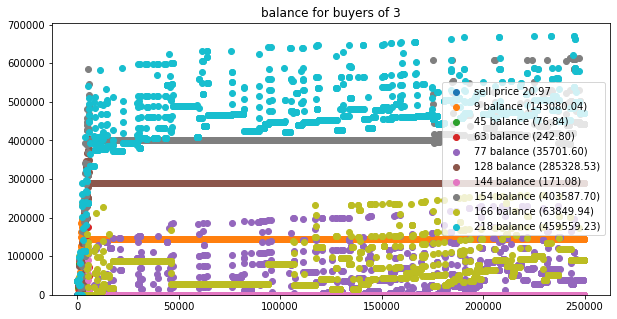

In [95]:
plt.subplots_adjust(right=0.7)
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
plt.figure(figsize=(10,5))
plt.scatter(df1.index, df1[product_id], label=f'sell price {df1[product_id].mean():.2f}', color=colors[0])
for agent, color in zip(df2["agent"].unique(), colors[1:]):
    plt.scatter(balance_df[balance_df["agent"] == agent]["tick"], balance_df[balance_df["agent"] == agent]["balance"], color=color, label=f'{agent} balance ({balance_df[balance_df["agent"] == agent]["balance"].mean():.2f})')
plt.title(f'balance for buyers of {product_id}')
plt.legend(loc="right")
plt.ylim(0)

In [96]:
np.where(agent_goods_df[product_id])

(array([  3,  32,  33,  75, 135, 156, 216, 271]),)

(0.0, 16214.173074485027)

<Figure size 432x288 with 0 Axes>

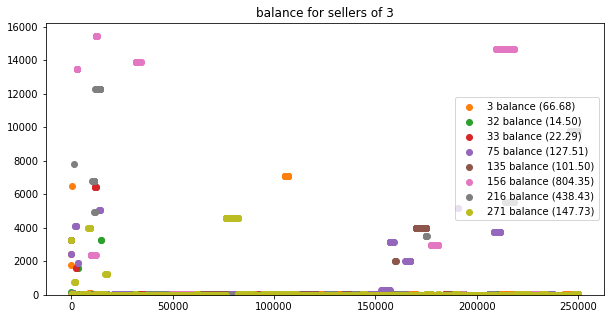

In [97]:
plt.subplots_adjust(right=0.7)
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
plt.figure(figsize=(10,5))
#plt.scatter(df1.index, df1[product_id], label=f'sell price {df1[product_id].mean():.2f}', color=colors[0])
for agent, color in zip(np.where(agent_goods_df[product_id])[0], colors[1:]):
    plt.scatter(balance_df[balance_df["agent"] == agent]["tick"], balance_df[balance_df["agent"] == agent]["balance"], color=color, label=f'{agent} balance ({balance_df[balance_df["agent"] == agent]["balance"].mean():.2f})')
plt.title(f'balance for sellers of {product_id}')
plt.legend(loc="right")
plt.ylim(0)

### Sellers for the Market

In [98]:
np.where(agent_goods_df[product_id] == 1)

(array([  3,  32,  33,  75, 135, 156, 216, 271]),)

Amounts Sold

In [99]:
transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)].groupby("seller")["amount"].sum()

seller
3      252910.0
32     255918.0
33     283781.0
75     270931.0
135    311414.0
156    291850.0
216    280948.0
271    283230.0
Name: amount, dtype: float64

Time ranges of sales

In [100]:
transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)].groupby("seller")["tick"].describe()

,count,mean,std,min,25%,50%,75%,max
seller,,,,,,,,
3,164.0,81679.408537,83001.564785,78.0,3067.00,59934.0,156440.00,245429.0
32,162.0,90515.716049,87513.495981,79.0,4600.25,62781.0,174982.00,245646.0
33,170.0,95527.794118,86131.165616,79.0,4326.25,90484.5,176971.25,247398.0
75,166.0,95257.903614,85815.063476,78.0,3815.25,91032.0,169727.00,247472.0
135,188.0,95354.856383,86331.296542,76.0,5348.25,78512.5,181789.25,247763.0
156,166.0,84942.620482,85017.425147,75.0,2556.00,60043.5,163940.75,247398.0
216,166.0,84484.463855,85876.316284,77.0,1699.00,46940.0,165054.00,245574.0
271,168.0,96877.422619,88217.467613,74.0,4636.50,90922.5,177391.00,247690.0


Prices for transactions

In [101]:
transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)].groupby("seller")["price"].describe()

,count,mean,std,min,25%,50%,75%,max
seller,,,,,,,,
3,164.0,21.823324,1.629092,20.845522,20.926138,21.090450,22.260966,28.128479
32,162.0,21.804363,1.733971,20.845694,20.890552,21.056338,22.261029,28.128479
33,170.0,21.765937,1.689802,20.845813,20.901334,21.066026,22.141810,28.128479
75,166.0,21.669692,1.487891,20.841323,20.899065,21.063815,22.141810,28.128479
135,188.0,21.624850,1.434294,20.844038,20.907531,21.062154,22.141810,28.128479
156,166.0,22.073409,2.130683,20.844095,20.910742,21.084908,22.260966,28.128479
216,166.0,22.169362,2.219904,20.842496,20.932459,21.083881,22.261029,28.128479
271,168.0,21.739134,1.649495,20.845632,20.908319,21.063815,22.260966,28.128479


Desired sell prices

In [102]:
sell_price_df[sell_price_df[product_id] < np.inf][["agent", "tick", product_id]].groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
3,3425.0,21.052571,0.195541,20.84123,21.051748,21.051748,21.051748,25.262098
32,3425.0,21.040587,0.075090,20.84123,21.051748,21.051748,21.051748,23.000000
33,3425.0,21.042124,0.074525,20.84123,21.051748,21.051748,21.051748,23.000000
75,3425.0,21.041755,0.074477,20.84123,21.051748,21.051748,21.051748,23.000000
135,3425.0,21.043476,0.073111,20.84123,21.051748,21.051748,21.051748,23.000000
156,3425.0,21.042246,0.074193,20.84123,21.051748,21.051748,21.051748,23.000000
216,3425.0,21.055414,0.199066,20.84123,21.051748,21.051748,21.051748,25.262098
271,3425.0,21.041509,0.074963,20.84123,21.051748,21.051748,21.051748,23.000000


Min Sell Prices

In [103]:
min_sell_price_df[sell_price_df[product_id] < np.inf][["agent", "tick", product_id]].groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
3,3425.0,20.963607,0.321858,19.788643,21.051748,21.051748,21.051748,21.051748
32,3425.0,20.961026,0.326178,19.788643,21.051748,21.051748,21.051748,21.051748
33,3425.0,20.967295,0.315547,19.788643,21.051748,21.051748,21.051748,21.051748
75,3425.0,20.966189,0.317458,19.788643,21.051748,21.051748,21.051748,21.051748
135,3425.0,20.974671,0.302394,19.788643,21.051748,21.051748,21.051748,21.051748
156,3425.0,20.968401,0.313620,19.788643,21.051748,21.051748,21.051748,21.051748
216,3425.0,20.969139,0.312327,19.788643,21.051748,21.051748,21.051748,21.051748
271,3425.0,20.964345,0.320609,19.788643,21.051748,21.051748,21.051748,21.051748


Product inventory

In [104]:
inventory_df[inventory_df["agent"].isin(np.where(agent_goods_df[product_id])[0])].groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
3,3425.0,4702.910949,451.128884,0.0,4537.0,4711.0,4997.0,5056.0
32,3425.0,4457.927883,493.314526,10.0,4311.0,4532.0,4760.0,4887.0
33,3425.0,4538.475328,498.553500,10.0,4418.0,4664.0,4814.0,4883.0
75,3425.0,4016.205255,439.118463,10.0,3809.0,4126.0,4352.0,4450.0
135,3425.0,4588.732263,479.907410,10.0,4551.0,4672.0,4821.0,4961.0
156,3425.0,8601.540438,729.754414,10.0,8520.0,8773.0,8939.0,9089.0
216,3425.0,7819.943358,649.282755,10.0,7665.0,7943.0,8144.0,8240.0
271,3425.0,4758.861606,463.392945,10.0,4592.0,4815.0,5056.0,5192.0


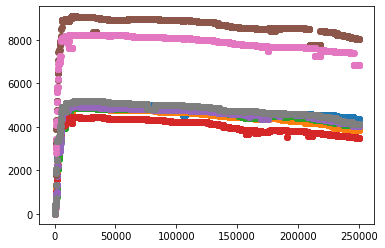

In [105]:
for agent in np.where(agent_goods_df[product_id])[0]:
    plt.scatter(inventory_df[inventory_df["agent"] == agent]["tick"], inventory_df[inventory_df["agent"] == agent][product_id])

Input inventory

In [106]:
production_needs = pd.Series(production_chain.adj_matrix[:,product_id] * production_chain.batch_sizes[product_id])
production_needs[production_needs > 0].to_frame()

,0


In [107]:
production_needs[production_needs > 0].index.to_list()

[]

In [108]:
input_ids = production_needs[production_needs > 0].index.to_list()
inventory_melt = pd.melt(inventory_df[inventory_df["agent"].isin(np.where(agent_goods_df[product_id])[0])][["agent", "tick"]+input_ids], id_vars=["agent", "tick"], value_vars=input_ids, var_name="product")
input_inventory_info = inventory_melt.groupby(["agent", "product"])["value"].describe()
input_inventory_info

,count,mean,std,min,25%,50%,75%,max


In [109]:
inventory_melt.groupby(["agent","tick"])["value"].min().groupby("agent").describe()

,count,mean,std,min,25%,50%,75%,max


Cannot sell ticks by seller

In [110]:
relevant_cannot_sell_df = cannot_sell_df[cannot_sell_df["agent"].isin(np.where(agent_goods_df[product_id])[0])][["tick", "agent", product_id]]
relevant_cannot_sell_df.groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
3,3425.0,705.766131,709.311559,0.0,146.0,365.0,1168.0,2701.0
32,3425.0,722.049927,719.678872,0.0,146.0,365.0,1241.0,2555.0
33,3425.0,732.600292,718.414027,0.0,146.0,438.0,1241.0,2628.0
75,3425.0,721.090803,712.111787,0.0,146.0,438.0,1241.0,2628.0
135,3425.0,788.058978,735.145089,0.0,219.0,438.0,1314.0,2701.0
156,3425.0,733.538102,713.699981,0.0,146.0,438.0,1241.0,2628.0
216,3425.0,727.634161,709.478138,0.0,146.0,438.0,1241.0,2628.0
271,3425.0,695.450219,693.362871,0.0,146.0,365.0,1168.0,2701.0


Text(0.5, 1.0, 'cannot sell 3')

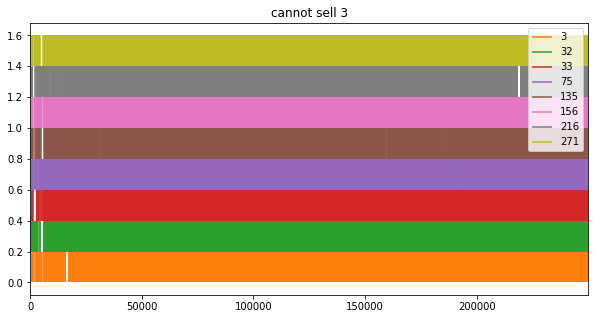

In [111]:
plt.figure(figsize=(10,5))
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
vtick = 0
vtick_step = 0.2
for agent, color in zip(relevant_cannot_sell_df["agent"].unique(), colors[1:]):
    plt.vlines(relevant_cannot_sell_df[(relevant_cannot_sell_df["agent"] == agent) & (relevant_cannot_sell_df[product_id]>100)]["tick"], ymin=vtick, ymax=vtick+vtick_step, label=f'{agent}', color=color)
    vtick += vtick_step
plt.legend()
plt.xlim(min_ticks, max_ticks)
plt.title(f'cannot sell {product_id}')

### Buyers for the Market

Total Amount Purchased

In [112]:
transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)].groupby("buyer")["amount"].sum()

buyer
9       39181.0
45       6414.0
63      21691.0
77     697096.0
128     64811.0
144     17380.0
154    220698.0
166    453221.0
218    674298.0
236     36192.0
Name: amount, dtype: float64

Time Ranges of Purchase

In [113]:
transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)].groupby("buyer")["tick"].describe()

,count,mean,std,min,25%,50%,75%,max
buyer,,,,,,,,
9,52.0,1334.519231,821.724335,79.0,791.00,1316.5,1972.25,2775.0
45,21.0,669.619048,740.403976,79.0,205.00,241.0,1027.00,2629.0
63,32.0,1744.218750,2184.470745,74.0,215.25,961.5,2063.25,5768.0
77,381.0,109295.272966,74251.506039,75.0,39859.00,106654.0,174982.00,245573.0
128,55.0,3091.490909,1883.675454,79.0,1063.50,3578.0,4563.50,5841.0
144,28.0,1879.464286,2481.153487,79.0,188.00,236.0,5184.25,5987.0
154,140.0,110455.628571,109341.590358,78.0,3341.00,90740.0,225133.25,247763.0
166,238.0,137271.600840,78028.834330,76.0,106818.25,164726.0,190950.75,247472.0
218,345.0,93436.121739,78467.787432,77.0,14601.00,82126.0,159725.00,247472.0


Prices Paid

In [114]:
transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)].groupby("buyer")["price"].describe()

,count,mean,std,min,25%,50%,75%,max
buyer,,,,,,,,
9,52.0,26.603185,2.516014,22.141810,26.303618,28.126647,28.126647,28.126647
45,21.0,24.416778,2.850226,22.141810,22.141810,22.261029,28.127396,28.127396
63,32.0,22.902043,0.582080,22.141810,22.231224,23.233706,23.401558,23.492418
77,381.0,21.081826,0.366350,20.841323,20.888965,20.954218,21.077293,23.000000
128,55.0,22.525961,0.164952,22.141810,22.584518,22.584518,22.584518,23.000000
144,28.0,22.304262,0.203784,22.141810,22.141810,22.261029,22.379363,23.000000
154,140.0,21.641861,0.654451,20.845923,20.880230,21.925781,22.261063,23.000000
166,238.0,21.233141,0.503002,20.842657,20.892122,21.000937,21.296972,23.000000
218,345.0,21.248092,0.523173,20.843431,20.898895,21.051930,21.223764,23.000000


Desired Buy Prices

In [115]:
buy_price_df[buy_price_df[product_id] > 0][["agent", "tick", product_id]].groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
9,3425.0,33.754826,0.421909,23.000000,33.757899,33.757899,33.757899,35.201547
45,3425.0,33.755922,0.422674,23.000000,33.758567,33.758567,33.758567,35.203043
63,3425.0,25.925692,0.124808,23.000000,25.933088,25.933088,25.933088,25.933088
77,3425.0,21.084408,0.589946,10.546919,20.935318,21.024061,21.079765,23.470517
128,3425.0,24.115820,0.034639,23.000000,24.117289,24.117289,24.117289,24.117289
144,3425.0,24.647945,0.150547,23.000000,24.671236,24.671236,24.671236,24.671236
154,3425.0,22.764641,1.089393,20.677664,21.335791,23.470378,23.470378,23.470378
166,3425.0,21.382916,0.545764,20.737939,20.967039,21.202593,21.691279,23.470354
218,3425.0,21.144615,0.493748,20.667385,20.929387,21.036247,21.108077,23.470309


In [116]:
max_buy_price_df[max_buy_price_df[product_id] > 0][["agent", "tick", product_id]].groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
9,3425.0,37.155406,0.266875,33.757899,37.153578,37.153578,37.153578,43.340699
45,3425.0,33.796077,0.419295,33.758567,33.758567,33.758567,33.758567,43.336934
63,3425.0,29.910031,1.316500,29.721845,29.721845,29.721845,29.721845,43.340512
77,3425.0,21.608690,2.728209,20.709080,20.945899,21.073274,21.148847,39.390325
128,3425.0,28.920838,0.940438,27.027405,28.805487,28.805487,28.805487,43.310796
144,3425.0,31.752182,1.091137,28.509116,31.602811,31.602811,31.602811,39.390325
154,3425.0,24.647243,2.645743,20.848657,21.335875,25.877685,25.877685,43.314265
166,3425.0,21.878140,2.689671,20.772637,21.029259,21.354110,21.691279,43.340587
218,3425.0,21.519338,2.135795,20.824292,20.962058,21.075605,21.217367,43.339826


Cannot buy ticks by buyer

In [117]:
relevant_cannot_buy_df = cannot_buy_df[cannot_buy_df["tick"].between(min_ticks, max_ticks) & cannot_buy_df["agent"].isin(np.where(production_goods[product_id]>0)[0])][["tick", "agent", product_id]]
relevant_cannot_buy_df.groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
9,3425.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
45,3425.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
63,3425.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
77,3425.0,7.182774,42.045041,0.0,0.0,0.0,0.0,511.0
128,3425.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
144,3425.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
154,3425.0,1.300146,16.165863,0.0,0.0,0.0,0.0,365.0
166,3425.0,4.625109,32.514063,0.0,0.0,0.0,0.0,511.0
218,3425.0,3.729927,27.219873,0.0,0.0,0.0,0.0,511.0


Behavior of one buyer

In [118]:
price_diff = (buy_price_df[buy_price_df["agent"] == agent].set_index("tick")[product_id] - sell_price_df.groupby("tick")[product_id].min())
price_diff[price_diff > 0].index

Int64Index([], dtype='int64', name='tick')

is transaction?
cannot buy?
has budget?
buy price at max price?
price compatible


Text(0.5, 1.0, 'behavior for buyer 9')

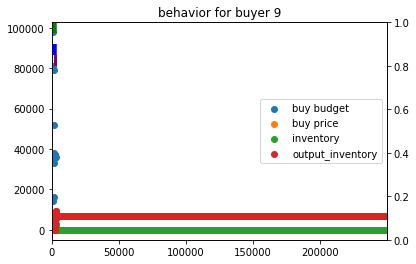

In [119]:
agent_id = relevant_cannot_buy_df["agent"].unique()[0]
agent_output = agent_goods_df.loc[agent_id].idxmax()
plt.scatter(buy_budget_df[buy_budget_df["agent"] == agent_id]["tick"], buy_budget_df[buy_budget_df["agent"] == agent_id][product_id], label=f'buy budget')
plt.scatter(buy_price_df[buy_price_df["agent"] == agent_id]["tick"], buy_price_df[buy_price_df["agent"] == agent_id][product_id], label=f'buy price')
plt.scatter(inventory_df[inventory_df["agent"] == agent_id]["tick"], inventory_df[inventory_df["agent"] == agent_id][product_id], label=f'inventory')
plt.scatter(inventory_df[inventory_df["agent"] == agent_id]["tick"], inventory_df[inventory_df["agent"] == agent_id][agent_output], label=f'output_inventory')
plt.legend(loc="right")
ax2 = plt.twinx()

print("is transaction?")
ax2.vlines(transaction_df[(transaction_df["buyer"] == agent_id) & (transaction_df["product"] == product_id)]["tick"], ymin=0.95, ymax=1.0, color="green")
print("cannot buy?")
ax2.vlines(cannot_buy_df[(cannot_buy_df["agent"] == agent_id) & (cannot_buy_df[product_id] > 0)]["tick"], ymin=0.90, ymax=0.95, color="red")
print("has budget?")
ax2.vlines(buy_budget_df[(buy_budget_df["agent"] == agent_id) & (buy_budget_df[product_id] > 0)]["tick"], ymin=0.85, ymax=0.90, color="blue")
print("buy price at max price?")
ax2.vlines(buy_price_df[(buy_price_df["agent"] == agent_id) & (max_buy_price_df[product_id] - buy_price_df[product_id] < econ_sim.PRICE_EPS)]["tick"], ymin=0.80, ymax=0.85, color="purple")
price_diff = (buy_price_df[buy_price_df["agent"] == agent].set_index("tick")[product_id] - sell_price_df.groupby("tick")[product_id].min())
print("price compatible")
ax2.vlines(price_diff[price_diff > 0].index, ymin=0.75, ymax=0.80, color="yellow")
ax2.set_ylim(0,1)

plt.xlim(min_ticks, max_ticks)

plt.title(f'behavior for buyer {agent_id}')

In [120]:
transaction_df[transaction_df["tick"].between(min_ticks, max_ticks) & (transaction_df["buyer"] == agent_id) & (transaction_df["product"] == product_id)]

,tick,product,buyer,seller,price,amount,value
287,79,3,9,33,23.000000,2.0,46.000000
308,80,3,9,32,23.000000,16.0,368.000000
1014,170,3,9,3,22.141810,196.0,4339.794719
1139,176,3,9,33,22.141810,185.0,4096.234811
1575,207,3,9,75,22.141810,215.0,4760.489105
1623,212,3,9,271,22.141810,244.0,5402.601589
1652,215,3,9,3,22.141810,278.0,6155.423121
1663,216,3,9,216,22.141810,262.0,5801.154165
1685,218,3,9,271,22.141810,217.0,4804.772724
1710,220,3,9,3,22.261029,307.0,6834.135805


<AxesSubplot:xlabel='tick'>

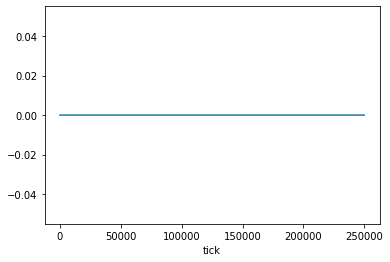

In [121]:
cannot_buy_df[cannot_buy_df["tick"].between(min_ticks, max_ticks) & (cannot_buy_df["agent"] == agent_id)].set_index("tick")[product_id].plot()

When cannot buy exceeds 0

In [122]:
relevant_cannot_buy_df[relevant_cannot_buy_df[product_id] > 0].groupby("agent")["tick"].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
77,140.0,149621.321429,71506.607754,21462.0,94516.75,148774.0,211061.25,245572.0
154,31.0,235163.612903,13047.393208,205422.0,228015.50,244550.0,245243.50,247908.0
166,98.0,175326.632653,35570.056658,117384.0,144558.25,163775.5,211389.75,247616.0
218,91.0,133273.934066,68554.121734,34602.0,64203.50,130159.0,184580.50,245791.0


(0.0, 249952.0)

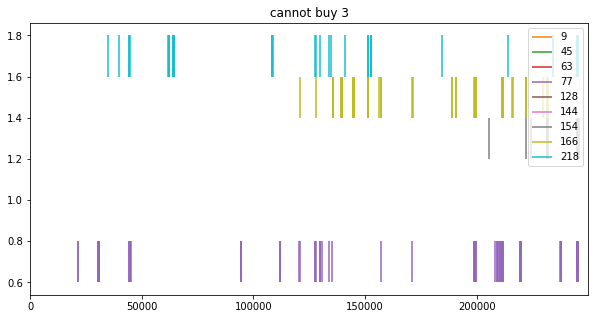

In [123]:
plt.figure(figsize=(10,5))
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
vtick = 0
vtick_step = 0.2
for agent, color in zip(relevant_cannot_buy_df["agent"].unique(), colors[1:]):
    plt.vlines(relevant_cannot_buy_df[(relevant_cannot_buy_df["agent"] == agent) & (relevant_cannot_buy_df[product_id]>100)]["tick"], ymin=vtick, ymax=vtick+vtick_step, label=f'{agent}', color=color)
    vtick += vtick_step
plt.legend()
plt.title(f'cannot buy {product_id}')
plt.xlim(min_ticks, max_ticks)

## Buy/Sell Price Investigation

In [124]:
df1[product_id].describe()

count    3425.000000
mean       20.971931
std         0.112390
min        20.841230
25%        20.841230
50%        21.051748
75%        21.051748
max        23.000000
Name: 3, dtype: float64

In [125]:
df2.groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
9,3425.0,33.754826,0.421909,23.000000,33.757899,33.757899,33.757899,35.201547
45,3425.0,33.755922,0.422674,23.000000,33.758567,33.758567,33.758567,35.203043
63,3425.0,25.925692,0.124808,23.000000,25.933088,25.933088,25.933088,25.933088
77,3425.0,21.084408,0.589946,10.546919,20.935318,21.024061,21.079765,23.470517
128,3425.0,24.115820,0.034639,23.000000,24.117289,24.117289,24.117289,24.117289
144,3425.0,24.647945,0.150547,23.000000,24.671236,24.671236,24.671236,24.671236
154,3425.0,22.764641,1.089393,20.677664,21.335791,23.470378,23.470378,23.470378
166,3425.0,21.382916,0.545764,20.737939,20.967039,21.202593,21.691279,23.470354
218,3425.0,21.144615,0.493748,20.667385,20.929387,21.036247,21.108077,23.470309


In [126]:
df2[df2["tick"] == df2["tick"].max()][product_id].max() - df1[product_id].iloc[-1]

14.153461661275205

In [127]:
(df2.groupby("tick")[product_id].max() - df1[product_id]).describe()

count    3425.000000
mean       14.215871
std         0.498709
min         0.000000
25%        14.153462
50%        14.153462
75%        14.363979
max        14.363979
Name: 3, dtype: float64

In [128]:
dfmb[dfmb["tick"] == dfmb["tick"].max()][product_id].max() - dfms[product_id].iloc[-1]

16.45054745456672

In [129]:
(dfmb.groupby("tick")[product_id].max() - dfms[product_id]).describe()

count    3425.000000
mean       16.975133
std         0.650295
min        16.450547
25%        16.450547
50%        16.450547
75%        17.713652
max        22.288951
Name: 3, dtype: float64

In [130]:
bp_s = (production_goods.loc[product_id] * buy_price_df[buy_price_df["agent"] == product_id].drop(["agent", "tick"], axis=1)).sum(axis=1)
mbp_s = (production_goods.loc[product_id] * max_buy_price_df[max_buy_price_df["agent"] == product_id].drop(["agent", "tick"], axis=1)).sum(axis=1)
sp_s = sell_price_df[sell_price_df["agent"] == product_id].drop(["agent", "tick"], axis=1).min(axis=1)
msp_s = min_sell_price_df[min_sell_price_df["agent"] == product_id].drop(["agent", "tick"], axis=1).min(axis=1)
price_df = pd.DataFrame({"cost":bp_s, "max_cost":mbp_s, "price":sp_s, "min_price":msp_s, "unit_profit":sp_s-bp_s})
price_df

,cost,max_cost,price,min_price,unit_profit
3,0.0,0.0,23.000000,21.051748,23.000000
303,0.0,0.0,22.770000,21.051748,22.770000
603,0.0,0.0,21.051748,21.051748,21.051748
903,0.0,0.0,21.051748,21.051748,21.051748
1203,0.0,0.0,21.051748,21.051748,21.051748
...,...,...,...,...,...
1026003,0.0,0.0,21.051748,21.051748,21.051748
1026303,0.0,0.0,20.841230,19.788643,20.841230
1026603,0.0,0.0,21.051748,21.051748,21.051748
1026903,0.0,0.0,21.051748,21.051748,21.051748


## Larger Scale Market Analysis

In [131]:
demand_units_df = (buy_budget_df.set_index(["agent", "tick"]) / buy_price_df.set_index(["agent", "tick"])).fillna(0.)
supply_units_df = (inventory_df.drop("tick", axis=1).set_index("agent") * agent_goods_df).rename_axis('agent').reset_index(level=0)
supply_units_df["tick"] = inventory_df["tick"]

### Supply Deficit

For each product, on average how many units of supply above demand are on the market

In [132]:
transaction_df.groupby("product")["amount"].sum() / transaction_df["tick"].max()

product
-1     82.697676
 0     11.019756
 1     10.663112
 2     12.069932
 3      8.923928
 4     19.290916
 5     16.120776
 6     10.556976
 7     10.088596
 8     11.879492
 9      8.624048
 10    19.103968
 11    15.551796
 12     2.403600
 13     2.520200
 14     1.771560
 15     1.736140
 16     1.929452
 17     1.413396
 18     0.046328
 19     0.119452
 20     0.048480
 21     0.077920
 22     0.122072
 23     0.061284
 24     0.000524
 25     0.000028
 26     0.007792
Name: amount, dtype: float64

In [133]:
demand_units_mean = demand_units_df.groupby("tick").sum().mean()
supply_units_mean = supply_units_df.groupby("tick").sum().mean().drop("agent")
surplus_df = pd.DataFrame({
    "agents": agent_goods_df.sum(axis=0),
    "supply": supply_units_mean,
    "supply_cv": ((supply_units_df.groupby("tick").sum()).std()/(supply_units_df.groupby("tick").sum()).mean()).drop("agent"),
    "demand": demand_units_mean,
    "demand_cv": (demand_units_df.groupby("tick").sum()).std()/(demand_units_df.groupby("tick").sum()).mean(),
    "surplus": supply_units_mean - demand_units_mean
})
surplus_df["min_input_surplus"] = 1./(pd.DataFrame(production_chain.adj_matrix).replace(0, np.nan).multiply(1./surplus_df["surplus"], axis=0).max(axis=0).fillna(np.inf))
surplus_df

,agents,supply,supply_cv,demand,demand_cv,surplus,min_input_surplus
0,28.0,223532.182482,4.845953,1761.240876,1.795994,221770.941606,0.000000
1,54.0,135013.235328,3.110308,1276.559708,2.084563,133736.675620,0.000000
2,8.0,85636.723796,6.101964,1111.938394,2.040793,84524.785401,0.000000
3,8.0,43484.597080,6.263052,1145.291095,1.996364,42339.305985,0.000000
4,37.0,220758.452263,2.883108,1253.497226,0.960667,219504.955036,0.000000
5,42.0,405779.166423,3.002050,1243.362044,1.782994,404535.804380,0.000000
6,23.0,108115.016642,4.078348,2447.405255,2.186974,105667.611387,221770.941606
7,24.0,134181.240292,3.854955,5794.138686,1.637600,128387.101606,133736.675620
8,6.0,45512.218978,7.081485,4535.454599,2.361266,40976.764380,84524.785401
9,10.0,73851.134599,5.498621,3406.787737,2.441314,70444.346861,42339.305985


In [134]:
surplus_df["surplus"] + surplus_df["min_input_surplus"]

0     221770.941606
1     133736.675620
2      84524.785401
3      42339.305985
4     219504.955036
5     404535.804380
6     327438.552993
7     262123.777226
8     125501.549781
9     112783.652847
10    219179.815474
11    544669.229489
12    -21319.903212
13     28007.336399
14    -34274.587263
15     21163.237032
16     11522.578978
17     11745.316302
18      1061.400000
19      2537.605645
20      1019.392247
21      1177.481869
22      3958.707482
23      2765.433431
24         8.580988
25         1.928626
26       117.656350
dtype: float64

## Cannot Buy or Sell

In [135]:
cannot_buy_df.drop("tick", axis=1).groupby("agent").max().max(axis=1)

agent
0      0
1      0
2      0
3      0
4      0
      ..
295    0
296    0
297    0
298    0
299    0
Length: 300, dtype: int64

Text(0.5, 1.0, 'distribution of max cannot buy ticks for agents')

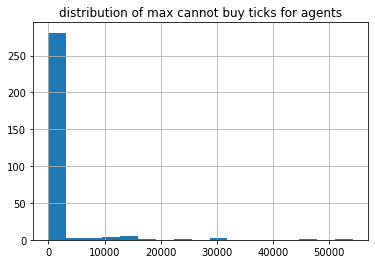

In [136]:
cannot_buy_df.drop("tick", axis=1).groupby("agent").max().max(axis=1).hist(bins=int(np.sqrt(cannot_buy_df["agent"].nunique())))
plt.title("distribution of max cannot buy ticks for agents")

Summary of cannot buy by good

In [137]:
maxes = cannot_buy_df.drop("tick", axis=1).groupby("agent").max()
describe_series = []
for product in agent_goods_df.columns:
    describe_series.append(maxes[product][production_goods[product] > 0].describe())
cannot_buy_summary = pd.concat(describe_series, axis=1).T
cannot_buy_summary["cv"] = cannot_buy_summary["std"] / cannot_buy_summary["mean"]
cannot_buy_summary["min_tick"] = transaction_df.groupby("product")["tick"].min()
cannot_buy_summary["max_tick"] = transaction_df.groupby("product")["tick"].max()
cannot_buy_summary

,count,mean,std,min,25%,50%,75%,max,cv,min_tick,max_tick
0,23.0,50.782609,132.857051,0.0,0.00,0.0,0.00,511.0,2.616192,74,249515
1,24.0,3.041667,14.901063,0.0,0.00,0.0,0.00,73.0,4.898979,74,249224
2,6.0,231.166667,232.762039,0.0,36.50,182.5,438.00,511.0,1.006901,74,247982
3,10.0,189.800000,248.629041,0.0,0.00,0.0,474.50,511.0,1.309953,74,247763
4,16.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0,NaN,74,249953
5,16.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0,NaN,74,249953
6,1.0,584.000000,NaN,584.0,584.00,584.0,584.00,584.0,NaN,82,248202
7,4.0,12026.750000,11205.182949,0.0,4051.50,12045.0,20020.25,24017.0,0.931688,80,249296
8,2.0,730.000000,206.475180,584.0,657.00,730.0,803.00,876.0,0.282843,78,246743
9,4.0,6186.750000,7028.848762,219.0,2354.25,4124.5,7957.00,16279.0,1.136113,76,249296


Text(0.5, 1.0, 'distribution of max cannot sell ticks for agents')

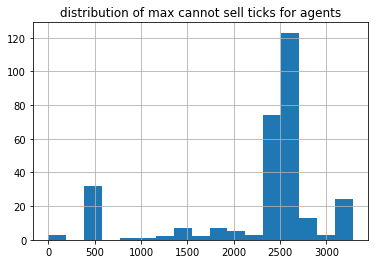

In [138]:
cannot_sell_df.drop("tick", axis=1).groupby("agent").max().max(axis=1).hist(bins=int(np.sqrt(cannot_sell_df["agent"].nunique())))
plt.title("distribution of max cannot sell ticks for agents")

<AxesSubplot:xlabel='tick'>

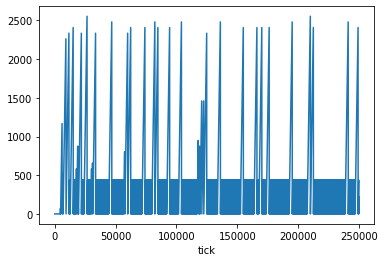

In [139]:
#cannot_sell_df[cannot_sell_df["agent"].isin(np.where(agent_goods_df[0] > 0)[0])]
cannot_sell_df[cannot_sell_df["agent"].isin([0])].set_index("tick")[0].plot()

In [140]:
transaction_df[(transaction_df["product"] == 0) & (transaction_df["seller"] == 0)].groupby("tick")["tick"].count()

tick
84        1
4746      1
4748      1
6060      1
6721      1
6865      1
9199      1
12704     1
16718     1
16792     1
17157     1
17887     1
18909     1
19202     1
19420     1
23945     2
23946     1
29639     1
30297     1
31100     1
44312     1
44313     1
56577     1
57453     1
59934     1
71615     1
79718     2
82272     1
91909     1
101544    1
101546    1
116875    1
117897    1
118918    1
119137    1
120744    1
122349    1
133518    1
133519    1
152425    1
163594    1
167609    1
173668    1
192502    2
207321    1
207322    1
207323    1
209949    1
238493    1
238494    1
246668    1
Name: tick, dtype: int64

In [141]:
cannot_sell_df[(cannot_sell_df["agent"] == 0) & (cannot_sell_df["tick"] > 46026)]

,agent,tick,0,1,2,3,4,5,6,7,...,17,18,19,20,21,22,23,24,25,26
189300,0,46063,1679,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
189600,0,46136,1752,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
189900,0,46209,1825,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
190200,0,46282,1898,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
190500,0,46355,1971,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1026000,0,249660,438,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1026300,0,249733,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1026600,0,249806,73,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1026900,0,249879,146,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Summary of cannot sell by product

In [142]:
maxes = cannot_sell_df.drop("tick", axis=1).groupby("agent").max()
describe_series = []
for product in agent_goods_df.columns:
    describe_series.append(maxes[product][agent_goods_df[product] > 0].describe())
cannot_sell_summary = pd.concat(describe_series, axis=1).T
cannot_sell_summary["cv"] = cannot_sell_summary["std"] / cannot_sell_summary["mean"]
cannot_sell_summary["min_tick"] = transaction_df.groupby("product")["tick"].min()
cannot_sell_summary["max_tick"] = transaction_df.groupby("product")["tick"].max()
cannot_sell_summary

,count,mean,std,min,25%,50%,75%,max,cv,min_tick,max_tick
0,28.0,2583.678571,85.083860,2482.0,2536.75,2555.0,2628.00,2774.0,0.032931,74,249515
1,54.0,2610.425926,115.148567,2482.0,2555.00,2555.0,2701.00,2920.0,0.044111,74,249224
2,8.0,2536.750000,51.618795,2482.0,2482.00,2555.0,2555.00,2628.0,0.020348,74,247982
3,8.0,2646.250000,51.618795,2555.0,2628.00,2628.0,2701.00,2701.0,0.019506,74,247763
4,37.0,2555.000000,17.206265,2482.0,2555.00,2555.0,2555.00,2628.0,0.006734,74,249953
5,42.0,2539.357143,86.127195,2482.0,2482.00,2482.0,2555.00,2774.0,0.033917,74,249953
6,23.0,1713.913043,933.266352,438.0,1241.00,1606.0,2263.00,3285.0,0.544524,82,248202
7,24.0,1149.750000,1176.745115,438.0,438.00,438.0,1971.00,3285.0,1.023479,80,249296
8,6.0,2895.666667,529.774166,1898.0,2810.50,3139.0,3193.75,3285.0,0.182954,78,246743
9,10.0,2569.600000,630.604331,1314.0,2244.75,2555.0,3139.00,3212.0,0.245410,76,249296


# Profit Analysis

## Basic Profit = Revenue - Cost

Sum up all revenue (from transactions, final goods are sunk elsewhere)
Sum up all costs (from transactions, basic resources are sourced elsewhere)
Account for inventory (using latest market prices)

profit = costs - revenue + value_of_goods_on_hand

In [143]:
revenue = transaction_df.groupby("seller")["value"].sum().reindex(list(range(agent_goods_df.shape[0])), fill_value=0)
costs = transaction_df.groupby("buyer")["value"].sum().reindex(list(range(agent_goods_df.shape[0])), fill_value=0)

In [144]:
costs.describe()

count    3.000000e+02
mean     3.548444e+06
std      1.222921e+07
min      9.636927e+03
25%      1.593190e+05
50%      3.199342e+05
75%      5.952723e+05
max      1.080328e+08
Name: value, dtype: float64

In [145]:
revenue.describe()

count    3.000000e+02
mean     6.317202e+06
std      3.384372e+07
min      1.891283e+02
25%      1.618619e+05
50%      3.515807e+05
75%      1.149025e+06
max      3.760304e+08
Name: value, dtype: float64

Profit (without accounting for inventory value):

In [146]:
(revenue-costs).describe()

count    3.000000e+02
mean     2.768758e+06
std      2.336974e+07
min     -6.707817e+06
25%     -1.197293e+03
50%     -5.984315e+02
75%      7.158446e+04
max      2.679975e+08
Name: value, dtype: float64

<AxesSubplot:>

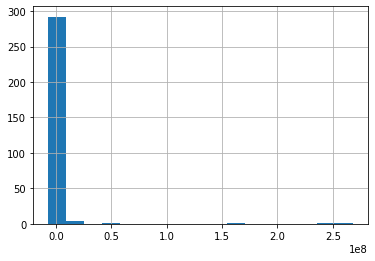

In [147]:
((revenue - costs)).hist(bins=int(np.sqrt(revenue.shape[0])))

How much value is sitting in inventory?

In [148]:
# estimate based on last price in the market
value_of_goods_on_hand = (inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].drop("tick", axis=1).set_index("agent") * transaction_df.groupby("product")["price"].nth(-1)).fillna(0).sum(axis=1)
value_of_goods_on_hand.describe()

count    3.000000e+02
mean     2.207959e+05
std      1.235995e+06
min      0.000000e+00
25%      7.515223e+03
50%      1.904848e+04
75%      4.997496e+04
max      1.429858e+07
dtype: float64

In [149]:
revenue.mean() - costs.mean()

2768757.9264348233

In [150]:
value_of_goods_on_hand.mean()/revenue.mean()

0.03495153207711402

Profit (accounting for value of goods on hand):

In [151]:
((revenue - costs) + value_of_goods_on_hand).describe()

count    3.000000e+02
mean     2.989554e+06
std      2.358615e+07
min     -4.184923e+05
25%      4.915049e+03
50%      4.889951e+04
75%      1.507935e+05
max      2.729358e+08
dtype: float64

<AxesSubplot:>

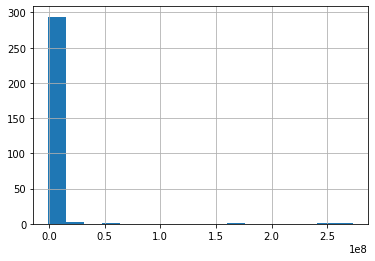

In [152]:
((revenue - costs) + value_of_goods_on_hand).hist(bins=int(np.sqrt(revenue.shape[0])))

## Further Investigation

### Profit by Product

In [153]:
revenue-costs

seller
0      -1196.961310
1       -599.147227
2      -2989.500448
3      -3437.012910
4      39707.156508
           ...     
295    -9448.392989
296     9344.159022
297     -598.869417
298    72419.638438
299    -1197.105536
Name: value, Length: 300, dtype: float64

In [154]:
agent_results = pd.DataFrame({"product":agent_goods_df.idxmax(axis=1), "profit":revenue-costs})
profit_by_product = agent_results.groupby("product")["profit"].describe().sort_values("mean")
profit_by_product["sem"] = agent_results.groupby("product").sem()
profit_by_product = profit_by_product.sort_values("mean", ascending=False)
profit_by_product

,count,mean,std,min,25%,50%,75%,max,sem
product,,,,,,,,,
25,1.0,2.679975e+08,NaN,2.679975e+08,2.679975e+08,2.679975e+08,2.679975e+08,2.679975e+08,NaN
26,1.0,2.471535e+08,NaN,2.471535e+08,2.471535e+08,2.471535e+08,2.471535e+08,2.471535e+08,NaN
24,1.0,1.697449e+08,NaN,1.697449e+08,1.697449e+08,1.697449e+08,1.697449e+08,1.697449e+08,NaN
23,1.0,4.869579e+07,NaN,4.869579e+07,4.869579e+07,4.869579e+07,4.869579e+07,4.869579e+07,NaN
14,2.0,2.074493e+07,4.168389e+06,1.779743e+07,1.927118e+07,2.074493e+07,2.221868e+07,2.369243e+07,2.947496e+06
10,16.0,2.960923e+06,4.592824e+06,1.919830e+05,7.022469e+05,8.030965e+05,1.689485e+06,1.373152e+07,1.148206e+06
15,1.0,2.598928e+06,NaN,2.598928e+06,2.598928e+06,2.598928e+06,2.598928e+06,2.598928e+06,NaN
12,6.0,1.981062e+06,7.243431e+05,1.193967e+06,1.486897e+06,1.762761e+06,2.526427e+06,2.990956e+06,2.957118e+05
16,2.0,7.705188e+05,1.655940e+04,7.588096e+05,7.646642e+05,7.705188e+05,7.763735e+05,7.822281e+05,1.170926e+04


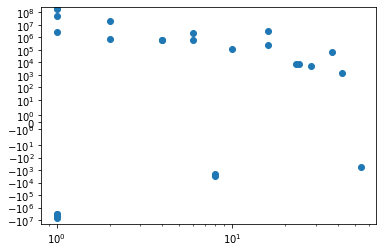

In [155]:
plt.scatter(profit_by_product["count"], profit_by_product["mean"])
plt.xscale("log")
plt.yscale("symlog")

<BarContainer object of 27 artists>

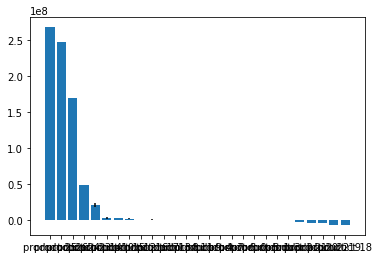

In [156]:
xvals = np.arange(len(profit_by_product))
width = 0.2
plt.bar(list(map(lambda x: f'product {x}', profit_by_product.index.to_list())), profit_by_product["mean"], yerr=profit_by_product["sem"].fillna(0))
#ax2 = plt.twinx()
#ax2.bar(xvals + width, profit_by_product["std"], width=width)

### Who Made a Profit?

In [157]:
print(len(np.where(((revenue - costs)) > 0)[0]))
np.where(((revenue - costs)) > 0)

130


(array([  4,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  23,
         24,  25,  26,  27,  29,  30,  34,  37,  40,  47,  49,  53,  55,
         58,  61,  65,  66,  67,  68,  69,  71,  73,  76,  77,  81,  82,
         84,  90,  92,  97,  98,  99, 101, 102, 103, 105, 111, 114, 115,
        116, 117, 119, 120, 121, 124, 127, 128, 130, 133, 136, 142, 143,
        148, 149, 150, 152, 154, 158, 161, 162, 165, 166, 167, 170, 171,
        173, 174, 180, 189, 191, 192, 194, 195, 198, 205, 207, 210, 216,
        218, 222, 225, 227, 228, 229, 230, 231, 234, 236, 238, 240, 241,
        244, 247, 248, 249, 250, 251, 257, 258, 260, 262, 263, 265, 267,
        269, 270, 273, 278, 280, 282, 283, 284, 286, 291, 292, 296, 298]),)

In [158]:
print(len(np.where(((revenue - costs) + value_of_goods_on_hand) > 0)[0]))
np.where(((revenue - costs) + value_of_goods_on_hand) > 0)

278


(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  18,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
         55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
         68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
         81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
         94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 105, 106, 108,
        109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
        123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
        136, 138, 139, 140, 141, 142, 143, 144, 145, 146, 148, 149, 150,
        152, 153, 154, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
        166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,
        179, 180, 181, 182, 183, 184, 185, 186, 187

In [159]:
revenue[((revenue - costs) + value_of_goods_on_hand) > 0].sort_values(ascending=False).head(10)

seller
25    3.760304e+08
26    3.548948e+08
24    2.469714e+08
23    7.213922e+07
20    5.931194e+07
68    5.330024e+07
18    4.828452e+07
21    4.344737e+07
14    3.991464e+07
82    3.815026e+07
Name: value, dtype: float64

In [160]:
costs[((revenue - costs) + value_of_goods_on_hand) > 0].sort_values(ascending=False)

buyer
25     1.080328e+08
26     1.077414e+08
24     7.722652e+07
20     6.270111e+07
18     5.499233e+07
           ...     
169    1.995410e+04
157    1.937796e+04
295    1.899708e+04
62     1.823335e+04
87     1.804222e+04
Name: value, Length: 278, dtype: float64

top profit takers

In [161]:
(revenue-costs).sort_values(ascending=False).head(20)

seller
25     2.679975e+08
26     2.471535e+08
24     1.697449e+08
23     4.869579e+07
68     2.369243e+07
14     1.779743e+07
142    1.373152e+07
90     1.369250e+07
247    8.203060e+06
98     2.990956e+06
244    2.719729e+06
15     2.598928e+06
12     1.946521e+06
161    1.775168e+06
170    1.660923e+06
263    1.626732e+06
171    1.583905e+06
189    1.579001e+06
180    1.456196e+06
27     1.193967e+06
Name: value, dtype: float64

In [162]:
agent_goods_df.loc[(revenue-costs).sort_values(ascending=False).head(20).index.to_series()].idxmax(axis=1)

25     25
26     26
24     24
23     23
68     14
14     14
142    10
90     10
247    10
98     12
244    12
15     15
12     12
161    10
170    10
263    17
171    10
189    12
180    12
27     12
dtype: int64

Taking into account value of goods on hand:

In [163]:
(revenue-costs+value_of_goods_on_hand).sort_values(ascending=False).head(20)

seller
25     2.729358e+08
26     2.471535e+08
24     1.701852e+08
23     5.447720e+07
68     2.369329e+07
14     1.779759e+07
142    1.374933e+07
90     1.369649e+07
247    8.251607e+06
18     7.590762e+06
20     6.268181e+06
21     4.161806e+06
98     2.991082e+06
244    2.913619e+06
15     2.717263e+06
12     2.017499e+06
161    1.825139e+06
263    1.817760e+06
189    1.740467e+06
170    1.710894e+06
dtype: float64

In [164]:
agent_goods_df.loc[(revenue-costs+value_of_goods_on_hand).sort_values(ascending=False).head(20).index.to_series()].idxmax(axis=1)

25     25
26     26
24     24
23     23
68     14
14     14
142    10
90     10
247    10
18     18
20     20
21     21
98     12
244    12
15     15
12     12
161    10
263    17
189    12
170    10
dtype: int64

### Who Made a Loss?

And selling what products?

In [165]:
print(len(np.where(((revenue - costs)) < 0)[0]))
np.where(((revenue - costs)) < 0)

170


(array([  0,   1,   2,   3,   5,  17,  18,  19,  20,  21,  22,  28,  31,
         32,  33,  35,  36,  38,  39,  41,  42,  43,  44,  45,  46,  48,
         50,  51,  52,  54,  56,  57,  59,  60,  62,  63,  64,  70,  72,
         74,  75,  78,  79,  80,  83,  85,  86,  87,  88,  89,  91,  93,
         94,  95,  96, 100, 104, 106, 107, 108, 109, 110, 112, 113, 118,
        122, 123, 125, 126, 129, 131, 132, 134, 135, 137, 138, 139, 140,
        141, 144, 145, 146, 147, 151, 153, 155, 156, 157, 159, 160, 163,
        164, 168, 169, 172, 175, 176, 177, 178, 179, 181, 182, 183, 184,
        185, 186, 187, 188, 190, 193, 196, 197, 199, 200, 201, 202, 203,
        204, 206, 208, 209, 211, 212, 213, 214, 215, 217, 219, 220, 221,
        223, 224, 226, 232, 233, 235, 237, 239, 242, 243, 245, 246, 252,
        253, 254, 255, 256, 259, 261, 264, 266, 268, 271, 272, 274, 275,
        276, 277, 279, 281, 285, 287, 288, 289, 290, 293, 294, 295, 297,
        299]),)

In [166]:
print(len(np.where(((revenue - costs) + value_of_goods_on_hand) < 0)[0]))
np.where(((revenue - costs) + value_of_goods_on_hand) < 0)

22


(array([ 17,  19,  31, 104, 107, 110, 137, 147, 151, 155, 208, 209, 211,
        213, 220, 223, 242, 264, 266, 279, 281, 293]),)

In [167]:
(revenue-costs).sort_values(ascending=True).head(20)

seller
18    -6.707817e+06
19    -6.166774e+06
22    -4.442983e+06
20    -3.389166e+06
21    -3.281756e+06
17    -1.840352e+05
164   -1.839093e+05
45    -3.509187e+04
144   -3.508967e+04
63    -3.508345e+04
203   -3.239007e+04
140   -9.897879e+03
266   -9.897608e+03
211   -9.896359e+03
281   -9.895778e+03
94    -9.895750e+03
193   -9.895660e+03
264   -9.895466e+03
279   -9.895345e+03
31    -9.894619e+03
Name: value, dtype: float64

In [168]:
agent_goods_df[((revenue - costs)) < 0].idxmax(axis=1).head(20)

0      0
1      1
2      2
3      3
5      5
17    17
18    18
19    19
20    20
21    21
22    22
28     1
31     6
32     3
33     3
35     6
36     1
38     5
39     1
41     5
dtype: int64

In [169]:
(revenue-costs + value_of_goods_on_hand).sort_values(ascending=True).head(20)

seller
19    -418492.271836
17     -40029.248355
266     -4805.363029
279     -4378.746550
264     -4301.259016
208     -4260.942502
281     -3991.667291
223     -3874.662811
104     -2868.602764
211     -2500.479487
31      -2457.973035
242     -2375.442909
147     -2325.161276
220     -2325.161276
107     -2325.161276
110     -2325.161276
137     -2325.161276
151     -1646.600598
155     -1586.333895
213     -1465.285022
dtype: float64

In [170]:
agent_goods_df[((revenue - costs) + value_of_goods_on_hand) < 0].idxmax(axis=1)

17     17
19     19
31      6
104     6
107     7
110     7
137     7
147     7
151     7
155     7
208     6
209     7
211     6
213     7
220     7
223     6
242     6
264     6
266     6
279     6
281     6
293     7
dtype: int64

## Recompute Profit from ending vs starting balance

And also account for value of goods on hand.

In [171]:
(balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent") - balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent"))["balance"]

agent
0      -1162.645786
1       -574.514103
2      -2823.720679
3      -3226.495430
4      37874.754074
           ...     
295    -9448.392989
296     9369.480811
297     -574.236293
298    72458.474020
299    -1162.790012
Name: balance, Length: 300, dtype: float64

<AxesSubplot:>

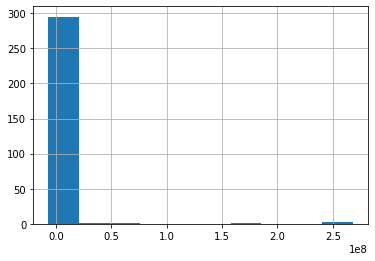

In [172]:
((balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent") - balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent"))["balance"]).hist()

<AxesSubplot:>

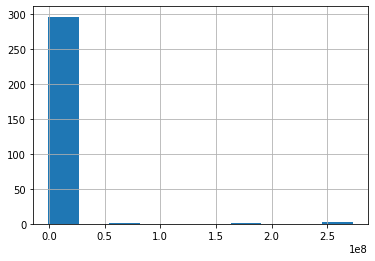

In [173]:
((balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent") - balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent"))["balance"] + value_of_goods_on_hand).hist()

## Profit By Prices

In [174]:
production_goods

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:>

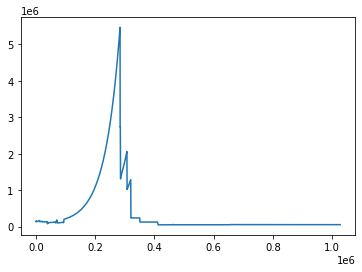

In [175]:
(buy_price_df[buy_price_df["agent"] == 26].drop(["agent", "tick"], axis=1) * production_goods.loc[26]).sum(axis=1).plot()

<AxesSubplot:>

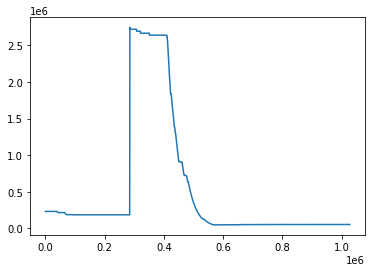

In [176]:
sell_price_df[sell_price_df["agent"] == 26][26].plot()

# Production Efficiency